In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
dataset_name = 'ravdess'
experiment_prefix = "scb14"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"

sr = 16000
batch_size = 4
in_channels = 1
kernel_size = 511
stride = 125
embedding_dim = 511
num_embeddings = 384
cls_dim = 512
learning_rate = 1e-4
max_num_tokens = 2048
num_classes = 4
commitment_cost = 0.1

In [6]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB14 as SCB
from omegaconf import OmegaConf as ocf

dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)
print(batch_size)

{'name': 'ravdess', 'dataset_class': 'WaveformDataset', 'root': 'ravdess/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label_emotion_key', 'feature_name': 'audio16k', 'num_classes': 8, 'label_values': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'classnames': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}
4


In [7]:
iconnet_config_path = f'config/model/m19win.yaml'
iconnet_config = ocf.load(iconnet_config_path)
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [256], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [9]:
n_epoch = 4

loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0, loss_recon=0, loss_cls=1)

trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=8)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [10]:
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.codebook.pt'
model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=512,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='minami',
    iconnet_config=iconnet_config,
)

In [12]:
trainer.setup(model=model, lr=learning_rate)

In [13]:
trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|▏                              | 0.4927536231884051/100 [00:35<4:45:13, 171.98s/it]

Epoch: 1	Loss: 2.249 [perplexity=140.181, loss_vq=0.041, loss_recon=4.930, loss_cls=2.249]	Val_acc: 6/27 (22.22%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=1.step=59.loss=2.249.val_acc=0.222.pt


  1%|▍                                | 1.297101449275365/100 [01:18<1:00:19, 36.67s/it]

Correct: 50/135 (0.3704)
Saved new best test model: ../scb14_models/ravdess/model.epoch=1.step=117.test_acc=0.3704.pt
{'acc_unweighted': tensor(0.3205, device='cuda:0'),
 'acc_weighted': tensor(0.3704, device='cuda:0'),
 'f1s_unweighted': tensor(0.2370, device='cuda:0'),
 'f1s_weighted': tensor(0.2739, device='cuda:0'),
 'rocauc': tensor(0.7422, device='cuda:0'),
 'uar': tensor(0.3205, device='cuda:0'),
 'wap': tensor(0.2193, device='cuda:0')}
{'acc_detail': tensor([0.0000, 0.0000, 0.6410, 0.6410], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.5208, 0.4274], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.4386, 0.3205], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.0000, 0.6410, 0.6410], device='cuda:0'),
 'rocauc_detail': tensor([0.8652, 0.7781, 0.7487, 0.5769], device='cuda:0')}
tensor([[ 0,  0,  3, 35],
        [ 0,  0, 15,  4],
        [ 0,  0, 25, 14],
        [ 0,  0, 14, 25]], device='cuda:0')


  2%|▌                               | 1.789855072463773/100 [01:53<4:47:26, 175.61s/it]

Epoch: 2	Loss: 1.689 [perplexity=189.423, loss_vq=0.041, loss_recon=4.613, loss_cls=1.689]	Val_acc: 8/27 (29.63%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=2.step=176.loss=1.689.val_acc=0.296.pt


  3%|▊                              | 2.7608695652174005/100 [03:00<4:48:00, 177.71s/it]

Epoch: 3	Loss: 0.924 [perplexity=90.979, loss_vq=0.043, loss_recon=4.297, loss_cls=0.924]	Val_acc: 13/27 (48.15%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=3.step=293.loss=0.924.val_acc=0.481.pt


  4%|█▏                              | 3.731884057971028/100 [04:05<4:43:34, 176.75s/it]

Epoch: 4	Loss: 1.186 [perplexity=75.292, loss_vq=0.037, loss_recon=4.788, loss_cls=1.186]	Val_acc: 13/27 (48.15%)



  5%|█▌                              | 4.702898550724612/100 [05:11<4:41:10, 177.03s/it]

Epoch: 5	Loss: 1.483 [perplexity=127.139, loss_vq=0.037, loss_recon=3.679, loss_cls=1.483]	Val_acc: 11/27 (40.74%)



  6%|█▊                               | 5.67391304347818/100 [06:21<4:55:58, 188.27s/it]

Epoch: 6	Loss: 0.938 [perplexity=81.164, loss_vq=0.033, loss_recon=2.941, loss_cls=0.938]	Val_acc: 14/27 (51.85%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=6.step=644.loss=0.938.val_acc=0.519.pt


  7%|██▏                             | 6.644927536231748/100 [07:32<4:45:59, 183.81s/it]

Epoch: 7	Loss: 0.888 [perplexity=119.365, loss_vq=0.038, loss_recon=4.168, loss_cls=0.888]	Val_acc: 15/27 (55.56%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=7.step=761.loss=0.888.val_acc=0.556.pt


  8%|██▍                             | 7.615942028985316/100 [08:42<4:53:01, 190.31s/it]

Epoch: 8	Loss: 1.060 [perplexity=136.969, loss_vq=0.036, loss_recon=4.403, loss_cls=1.060]	Val_acc: 11/27 (40.74%)



  9%|██▋                             | 8.586956521738884/100 [09:53<4:49:05, 189.74s/it]

Epoch: 9	Loss: 1.308 [perplexity=127.519, loss_vq=0.041, loss_recon=4.749, loss_cls=1.308]	Val_acc: 10/27 (37.04%)



 10%|███                             | 9.557971014492452/100 [11:03<4:39:59, 185.74s/it]

Epoch: 10	Loss: 0.941 [perplexity=103.371, loss_vq=0.035, loss_recon=4.788, loss_cls=0.941]	Val_acc: 16/27 (59.26%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=10.step=1112.loss=0.941.val_acc=0.593.pt


 11%|███▎                            | 10.52898550724602/100 [12:13<4:36:05, 185.14s/it]

Epoch: 11	Loss: 1.332 [perplexity=80.078, loss_vq=0.034, loss_recon=5.590, loss_cls=1.332]	Val_acc: 13/27 (48.15%)



 11%|███▉                               | 11.33333333333293/100 [12:59<55:43, 37.71s/it]

Correct: 72/135 (0.5333)
Saved new best test model: ../scb14_models/ravdess/model.epoch=11.step=1287.test_acc=0.5333.pt
{'acc_unweighted': tensor(0.4649, device='cuda:0'),
 'acc_weighted': tensor(0.5333, device='cuda:0'),
 'f1s_unweighted': tensor(0.4386, device='cuda:0'),
 'f1s_weighted': tensor(0.5018, device='cuda:0'),
 'rocauc': tensor(0.8191, device='cuda:0'),
 'uar': tensor(0.4649, device='cuda:0'),
 'wap': tensor(0.5214, device='cuda:0')}
{'acc_detail': tensor([0.5263, 0.0000, 0.7179, 0.6154], device='cuda:0'),
 'f1s_detail': tensor([0.6667, 0.0000, 0.5714, 0.5161], device='cuda:0'),
 'precision_detail': tensor([0.9091, 0.0000, 0.4746, 0.4444], device='cuda:0'),
 'recall_detail': tensor([0.5263, 0.0000, 0.7179, 0.6154], device='cuda:0'),
 'rocauc_detail': tensor([0.8993, 0.8503, 0.7911, 0.7358], device='cuda:0')}
tensor([[20,  0,  3, 15],
        [ 0,  0, 15,  4],
        [ 0,  0, 28, 11],
        [ 2,  0, 13, 24]], device='cuda:0')


 12%|███▋                           | 11.826086956521308/100 [13:36<4:31:36, 184.82s/it]

Epoch: 12	Loss: 1.195 [perplexity=122.034, loss_vq=0.040, loss_recon=5.264, loss_cls=1.195]	Val_acc: 13/27 (48.15%)



 13%|███▉                           | 12.797101449274876/100 [14:46<4:18:43, 178.01s/it]

Epoch: 13	Loss: 1.111 [perplexity=123.798, loss_vq=0.037, loss_recon=4.573, loss_cls=1.111]	Val_acc: 15/27 (55.56%)



 14%|████▎                          | 13.768115942028444/100 [15:52<4:14:30, 177.09s/it]

Epoch: 14	Loss: 0.609 [perplexity=124.568, loss_vq=0.041, loss_recon=3.115, loss_cls=0.609]	Val_acc: 13/27 (48.15%)



 15%|████▌                          | 14.739130434782012/100 [16:59<4:09:23, 175.51s/it]

Epoch: 15	Loss: 0.979 [perplexity=124.020, loss_vq=0.043, loss_recon=3.940, loss_cls=0.979]	Val_acc: 12/27 (44.44%)



 16%|█████                           | 15.71014492753558/100 [18:06<4:09:19, 177.48s/it]

Epoch: 16	Loss: 0.202 [perplexity=170.740, loss_vq=0.046, loss_recon=3.379, loss_cls=0.202]	Val_acc: 11/27 (40.74%)



 17%|█████▎                          | 16.68115942028915/100 [19:13<4:08:47, 179.16s/it]

Epoch: 17	Loss: 1.137 [perplexity=77.899, loss_vq=0.035, loss_recon=5.175, loss_cls=1.137]	Val_acc: 14/27 (51.85%)



 18%|█████▍                         | 17.652173913042716/100 [20:19<4:02:31, 176.70s/it]

Epoch: 18	Loss: 0.391 [perplexity=77.434, loss_vq=0.039, loss_recon=3.003, loss_cls=0.391]	Val_acc: 15/27 (55.56%)



 19%|█████▊                         | 18.623188405796284/100 [21:25<3:58:23, 175.77s/it]

Epoch: 19	Loss: 0.606 [perplexity=114.148, loss_vq=0.035, loss_recon=4.297, loss_cls=0.606]	Val_acc: 11/27 (40.74%)



 20%|██████                         | 19.594202898549852/100 [22:32<3:55:24, 175.66s/it]

Epoch: 20	Loss: 0.817 [perplexity=126.286, loss_vq=0.041, loss_recon=4.564, loss_cls=0.817]	Val_acc: 12/27 (44.44%)



 21%|██████▌                         | 20.56521739130342/100 [23:37<3:50:59, 174.48s/it]

Epoch: 21	Loss: 0.067 [perplexity=146.982, loss_vq=0.042, loss_recon=4.474, loss_cls=0.067]	Val_acc: 11/27 (40.74%)



 21%|███████▍                           | 21.36956521739033/100 [24:21<47:05, 35.94s/it]

Correct: 89/135 (0.6593)
Saved new best test model: ../scb14_models/ravdess/model.epoch=21.step=2457.test_acc=0.6593.pt
{'acc_unweighted': tensor(0.5754, device='cuda:0'),
 'acc_weighted': tensor(0.6593, device='cuda:0'),
 'f1s_unweighted': tensor(0.5380, device='cuda:0'),
 'f1s_weighted': tensor(0.6157, device='cuda:0'),
 'rocauc': tensor(0.8699, device='cuda:0'),
 'uar': tensor(0.5754, device='cuda:0'),
 'wap': tensor(0.5893, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.0000, 0.7949, 0.7436], device='cuda:0'),
 'f1s_detail': tensor([0.8056, 0.0000, 0.6392, 0.7073], device='cuda:0'),
 'precision_detail': tensor([0.8529, 0.0000, 0.5345, 0.6744], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.0000, 0.7949, 0.7436], device='cuda:0'),
 'rocauc_detail': tensor([0.9361, 0.8662, 0.8502, 0.8272], device='cuda:0')}
tensor([[29,  0,  3,  6],
        [ 0,  0, 17,  2],
        [ 2,  0, 31,  6],
        [ 3,  0,  7, 29]], device='cuda:0')


 22%|██████▉                         | 21.86231884057871/100 [24:56<3:52:10, 178.28s/it]

Epoch: 22	Loss: 0.712 [perplexity=112.448, loss_vq=0.042, loss_recon=4.314, loss_cls=0.712]	Val_acc: 16/27 (59.26%)



 23%|███████                        | 22.833333333332277/100 [26:02<3:46:13, 175.90s/it]

Epoch: 23	Loss: 0.491 [perplexity=123.373, loss_vq=0.041, loss_recon=4.184, loss_cls=0.491]	Val_acc: 12/27 (44.44%)



 24%|███████▍                       | 23.804347826085845/100 [27:08<3:48:30, 179.93s/it]

Epoch: 24	Loss: 2.480 [perplexity=78.985, loss_vq=0.039, loss_recon=4.585, loss_cls=2.480]	Val_acc: 13/27 (48.15%)



 25%|███████▋                       | 24.775362318839413/100 [28:14<3:42:11, 177.22s/it]

Epoch: 25	Loss: 0.186 [perplexity=84.637, loss_vq=0.035, loss_recon=5.138, loss_cls=0.186]	Val_acc: 14/27 (51.85%)



 26%|████████▏                       | 25.74637681159298/100 [29:20<3:41:22, 178.89s/it]

Epoch: 26	Loss: 0.141 [perplexity=144.746, loss_vq=0.041, loss_recon=3.580, loss_cls=0.141]	Val_acc: 14/27 (51.85%)



 27%|████████▌                       | 26.71739130434655/100 [30:26<3:38:39, 179.02s/it]

Epoch: 27	Loss: 0.157 [perplexity=99.623, loss_vq=0.036, loss_recon=4.297, loss_cls=0.157]	Val_acc: 15/27 (55.56%)



 28%|████████▌                      | 27.688405797100117/100 [31:33<3:31:32, 175.53s/it]

Epoch: 28	Loss: 0.023 [perplexity=83.678, loss_vq=0.036, loss_recon=2.638, loss_cls=0.023]	Val_acc: 16/27 (59.26%)



 29%|████████▉                      | 28.659420289853685/100 [32:39<3:29:51, 176.50s/it]

Epoch: 29	Loss: 0.002 [perplexity=123.463, loss_vq=0.040, loss_recon=4.508, loss_cls=0.002]	Val_acc: 16/27 (59.26%)



 30%|█████████▏                     | 29.630434782607253/100 [33:45<3:28:30, 177.78s/it]

Epoch: 30	Loss: 1.607 [perplexity=140.545, loss_vq=0.045, loss_recon=4.366, loss_cls=1.607]	Val_acc: 14/27 (51.85%)



 31%|█████████▊                      | 30.60144927536082/100 [34:51<3:24:15, 176.59s/it]

Epoch: 31	Loss: 0.010 [perplexity=159.753, loss_vq=0.042, loss_recon=4.875, loss_cls=0.010]	Val_acc: 16/27 (59.26%)



 31%|██████████▉                        | 31.40579710144773/100 [35:34<41:22, 36.20s/it]

Correct: 84/135 (0.6222)
{'acc_unweighted': tensor(0.6117, device='cuda:0'),
 'acc_weighted': tensor(0.6222, device='cuda:0'),
 'f1s_unweighted': tensor(0.5880, device='cuda:0'),
 'f1s_weighted': tensor(0.6078, device='cuda:0'),
 'rocauc': tensor(0.8668, device='cuda:0'),
 'uar': tensor(0.6117, device='cuda:0'),
 'wap': tensor(0.6273, device='cuda:0')}
{'acc_detail': tensor([0.8947, 0.5263, 0.3333, 0.6923], device='cuda:0'),
 'f1s_detail': tensor([0.7907, 0.4444, 0.4333, 0.6835], device='cuda:0'),
 'precision_detail': tensor([0.7083, 0.3846, 0.6190, 0.6750], device='cuda:0'),
 'recall_detail': tensor([0.8947, 0.5263, 0.3333, 0.6923], device='cuda:0'),
 'rocauc_detail': tensor([0.9220, 0.8584, 0.8595, 0.8272], device='cuda:0')}
tensor([[34,  0,  0,  4],
        [ 2, 10,  3,  4],
        [ 6, 15, 13,  5],
        [ 6,  1,  5, 27]], device='cuda:0')


 32%|██████████▏                     | 31.89855072463611/100 [36:09<3:21:25, 177.46s/it]

Epoch: 32	Loss: 0.009 [perplexity=92.823, loss_vq=0.033, loss_recon=5.128, loss_cls=0.009]	Val_acc: 14/27 (51.85%)



 33%|██████████▌                     | 32.86956521738968/100 [37:16<3:21:22, 179.99s/it]

Epoch: 33	Loss: 0.004 [perplexity=120.472, loss_vq=0.046, loss_recon=6.232, loss_cls=0.004]	Val_acc: 19/27 (70.37%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=33.step=3803.loss=0.004.val_acc=0.704.pt


 34%|██████████▍                    | 33.840579710143246/100 [38:22<3:12:24, 174.49s/it]

Epoch: 34	Loss: 0.004 [perplexity=116.602, loss_vq=0.037, loss_recon=4.945, loss_cls=0.004]	Val_acc: 18/27 (66.67%)



 35%|███████████▏                    | 34.81159420289681/100 [39:28<3:12:12, 176.91s/it]

Epoch: 35	Loss: 0.001 [perplexity=122.077, loss_vq=0.034, loss_recon=3.820, loss_cls=0.001]	Val_acc: 16/27 (59.26%)



 36%|███████████▍                    | 35.78260869565038/100 [40:34<3:08:38, 176.25s/it]

Epoch: 36	Loss: 0.172 [perplexity=131.012, loss_vq=0.037, loss_recon=2.874, loss_cls=0.172]	Val_acc: 14/27 (51.85%)



 37%|███████████▊                    | 36.75362318840395/100 [41:41<3:05:58, 176.43s/it]

Epoch: 37	Loss: 0.002 [perplexity=95.837, loss_vq=0.040, loss_recon=5.064, loss_cls=0.002]	Val_acc: 18/27 (66.67%)



 38%|████████████                    | 37.72463768115752/100 [42:47<3:04:18, 177.57s/it]

Epoch: 38	Loss: 0.005 [perplexity=111.495, loss_vq=0.037, loss_recon=4.230, loss_cls=0.005]	Val_acc: 16/27 (59.26%)



 39%|███████████▉                   | 38.695652173911085/100 [43:53<3:00:39, 176.81s/it]

Epoch: 39	Loss: 0.000 [perplexity=126.364, loss_vq=0.042, loss_recon=4.542, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 40%|████████████▋                   | 39.66666666666465/100 [44:59<2:57:52, 176.90s/it]

Epoch: 40	Loss: 0.003 [perplexity=155.766, loss_vq=0.047, loss_recon=4.279, loss_cls=0.003]	Val_acc: 18/27 (66.67%)



 41%|█████████████                   | 40.63768115941822/100 [46:05<2:57:46, 179.69s/it]

Epoch: 41	Loss: 0.001 [perplexity=104.155, loss_vq=0.036, loss_recon=5.220, loss_cls=0.001]	Val_acc: 17/27 (62.96%)



 41%|██████████████▌                    | 41.44202898550513/100 [46:49<35:25, 36.30s/it]

Correct: 92/135 (0.6815)
Saved new best test model: ../scb14_models/ravdess/model.epoch=41.step=4797.test_acc=0.6815.pt
{'acc_unweighted': tensor(0.6899, device='cuda:0'),
 'acc_weighted': tensor(0.6815, device='cuda:0'),
 'f1s_unweighted': tensor(0.6677, device='cuda:0'),
 'f1s_weighted': tensor(0.6790, device='cuda:0'),
 'rocauc': tensor(0.8802, device='cuda:0'),
 'uar': tensor(0.6899, device='cuda:0'),
 'wap': tensor(0.6965, device='cuda:0')}
{'acc_detail': tensor([0.8947, 0.7368, 0.5385, 0.5897], device='cuda:0'),
 'f1s_detail': tensor([0.8293, 0.5833, 0.5915, 0.6667], device='cuda:0'),
 'precision_detail': tensor([0.7727, 0.4828, 0.6562, 0.7667], device='cuda:0'),
 'recall_detail': tensor([0.8947, 0.7368, 0.5385, 0.5897], device='cuda:0'),
 'rocauc_detail': tensor([0.9487, 0.9043, 0.8336, 0.8341], device='cuda:0')}
tensor([[34,  1,  1,  2],
        [ 0, 14,  4,  1],
        [ 5,  9, 21,  4],
        [ 5,  5,  6, 23]], device='cuda:0')


 42%|█████████████▍                  | 41.93478260869351/100 [47:24<2:51:39, 177.38s/it]

Epoch: 42	Loss: 0.000 [perplexity=67.141, loss_vq=0.033, loss_recon=6.177, loss_cls=0.000]	Val_acc: 20/27 (74.07%)

Saved new best val model: ../scb14_models/ravdess/model.epoch=42.step=4856.loss=0.000.val_acc=0.741.pt


 43%|█████████████▋                  | 42.90579710144708/100 [48:30<2:49:12, 177.81s/it]

Epoch: 43	Loss: 0.357 [perplexity=87.702, loss_vq=0.042, loss_recon=4.500, loss_cls=0.357]	Val_acc: 15/27 (55.56%)



 44%|█████████████▌                 | 43.876811594200646/100 [49:36<2:44:30, 175.88s/it]

Epoch: 44	Loss: 0.000 [perplexity=67.951, loss_vq=0.034, loss_recon=4.880, loss_cls=0.000]	Val_acc: 19/27 (70.37%)



 45%|█████████████▉                 | 44.847826086954214/100 [50:42<2:41:51, 176.08s/it]

Epoch: 45	Loss: 0.002 [perplexity=89.956, loss_vq=0.038, loss_recon=5.675, loss_cls=0.002]	Val_acc: 17/27 (62.96%)



 46%|██████████████▋                 | 45.81884057970778/100 [51:49<2:37:01, 173.88s/it]

Epoch: 46	Loss: 0.012 [perplexity=104.592, loss_vq=0.036, loss_recon=5.660, loss_cls=0.012]	Val_acc: 20/27 (74.07%)



 47%|██████████████▉                 | 46.78985507246135/100 [52:55<2:35:25, 175.26s/it]

Epoch: 47	Loss: 0.000 [perplexity=150.348, loss_vq=0.039, loss_recon=5.816, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 48%|███████████████▎                | 47.76086956521492/100 [54:01<2:34:02, 176.93s/it]

Epoch: 48	Loss: 0.002 [perplexity=159.984, loss_vq=0.039, loss_recon=4.633, loss_cls=0.002]	Val_acc: 16/27 (59.26%)



 49%|███████████████                | 48.731884057968486/100 [55:07<2:30:44, 176.42s/it]

Epoch: 49	Loss: 0.000 [perplexity=98.672, loss_vq=0.037, loss_recon=4.541, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 50%|███████████████▍               | 49.702898550722054/100 [56:14<2:28:11, 176.78s/it]

Epoch: 50	Loss: 0.000 [perplexity=126.865, loss_vq=0.038, loss_recon=5.529, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 51%|████████████████▏               | 50.67391304347562/100 [57:20<2:25:43, 177.25s/it]

Epoch: 51	Loss: 0.000 [perplexity=87.711, loss_vq=0.039, loss_recon=3.304, loss_cls=0.000]	Val_acc: 19/27 (70.37%)



 51%|██████████████████                 | 51.47826086956253/100 [58:03<29:21, 36.31s/it]

Correct: 95/135 (0.7037)
Saved new best test model: ../scb14_models/ravdess/model.epoch=51.step=5967.test_acc=0.7037.pt
{'acc_unweighted': tensor(0.7016, device='cuda:0'),
 'acc_weighted': tensor(0.7037, device='cuda:0'),
 'f1s_unweighted': tensor(0.6968, device='cuda:0'),
 'f1s_weighted': tensor(0.7052, device='cuda:0'),
 'rocauc': tensor(0.8834, device='cuda:0'),
 'uar': tensor(0.7016, device='cuda:0'),
 'wap': tensor(0.7144, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6842, 0.5897, 0.7692], device='cuda:0'),
 'f1s_detail': tensor([0.8169, 0.6341, 0.6301, 0.7059], device='cuda:0'),
 'precision_detail': tensor([0.8788, 0.5909, 0.6765, 0.6522], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6842, 0.5897, 0.7692], device='cuda:0'),
 'rocauc_detail': tensor([0.9455, 0.8997, 0.8563, 0.8323], device='cuda:0')}
tensor([[29,  0,  1,  8],
        [ 0, 13,  4,  2],
        [ 2,  8, 23,  6],
        [ 2,  1,  6, 30]], device='cuda:0')


 52%|████████████████▋               | 51.97101449275091/100 [58:38<2:19:16, 173.99s/it]

Epoch: 52	Loss: 0.000 [perplexity=107.341, loss_vq=0.043, loss_recon=3.560, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 53%|████████████████▉               | 52.94202898550448/100 [59:45<2:19:49, 178.27s/it]

Epoch: 53	Loss: 0.000 [perplexity=162.196, loss_vq=0.045, loss_recon=5.179, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 54%|████████████████▏             | 53.91304347825805/100 [1:00:51<2:16:11, 177.31s/it]

Epoch: 54	Loss: 0.000 [perplexity=141.726, loss_vq=0.037, loss_recon=3.828, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 55%|███████████████▉             | 54.884057971011615/100 [1:01:57<2:16:12, 181.15s/it]

Epoch: 55	Loss: 0.000 [perplexity=120.115, loss_vq=0.048, loss_recon=5.231, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 56%|████████████████▊             | 55.85507246376518/100 [1:03:03<2:10:10, 176.94s/it]

Epoch: 56	Loss: 0.000 [perplexity=149.677, loss_vq=0.048, loss_recon=4.101, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 57%|█████████████████             | 56.82608695651875/100 [1:04:09<2:06:27, 175.75s/it]

Epoch: 57	Loss: 0.000 [perplexity=157.525, loss_vq=0.040, loss_recon=4.932, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 58%|█████████████████▎            | 57.79710144927232/100 [1:05:15<2:05:07, 177.90s/it]

Epoch: 58	Loss: 0.000 [perplexity=161.965, loss_vq=0.045, loss_recon=3.368, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 59%|█████████████████▋            | 58.76811594202589/100 [1:06:22<2:01:19, 176.55s/it]

Epoch: 59	Loss: 0.000 [perplexity=139.341, loss_vq=0.042, loss_recon=5.100, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 60%|█████████████████▎           | 59.739130434779455/100 [1:07:28<1:56:58, 174.32s/it]

Epoch: 60	Loss: 0.001 [perplexity=133.944, loss_vq=0.046, loss_recon=4.812, loss_cls=0.001]	Val_acc: 18/27 (66.67%)



 61%|██████████████████▏           | 60.71014492753302/100 [1:08:35<1:57:49, 179.92s/it]

Epoch: 61	Loss: 0.000 [perplexity=100.238, loss_vq=0.039, loss_recon=4.739, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 62%|████████████████████▎            | 61.51449275361993/100 [1:09:18<23:14, 36.22s/it]

Correct: 95/135 (0.7037)
{'acc_unweighted': tensor(0.7016, device='cuda:0'),
 'acc_weighted': tensor(0.7037, device='cuda:0'),
 'f1s_unweighted': tensor(0.6954, device='cuda:0'),
 'f1s_weighted': tensor(0.7058, device='cuda:0'),
 'rocauc': tensor(0.8836, device='cuda:0'),
 'uar': tensor(0.7016, device='cuda:0'),
 'wap': tensor(0.7189, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6842, 0.5897, 0.7692], device='cuda:0'),
 'f1s_detail': tensor([0.8169, 0.6190, 0.6479, 0.6977], device='cuda:0'),
 'precision_detail': tensor([0.8788, 0.5652, 0.7188, 0.6383], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6842, 0.5897, 0.7692], device='cuda:0'),
 'rocauc_detail': tensor([0.9461, 0.9002, 0.8540, 0.8341], device='cuda:0')}
tensor([[29,  0,  0,  9],
        [ 0, 13,  4,  2],
        [ 2,  8, 23,  6],
        [ 2,  2,  5, 30]], device='cuda:0')


 62%|██████████████████▌           | 62.00724637680831/100 [1:09:53<1:50:03, 173.80s/it]

Epoch: 62	Loss: 0.000 [perplexity=99.395, loss_vq=0.039, loss_recon=3.335, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 63%|██████████████████▉           | 62.97826086956188/100 [1:11:00<1:49:04, 176.78s/it]

Epoch: 63	Loss: 0.000 [perplexity=120.054, loss_vq=0.037, loss_recon=5.685, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 64%|███████████████████▏          | 63.94927536231545/100 [1:12:06<1:47:22, 178.71s/it]

Epoch: 64	Loss: 0.000 [perplexity=112.290, loss_vq=0.039, loss_recon=3.115, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 65%|███████████████████▍          | 64.92028985506902/100 [1:13:13<1:44:15, 178.31s/it]

Epoch: 65	Loss: 0.000 [perplexity=119.841, loss_vq=0.039, loss_recon=5.413, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 66%|███████████████████▊          | 65.89130434782258/100 [1:14:21<1:41:00, 177.69s/it]

Epoch: 66	Loss: 0.000 [perplexity=150.363, loss_vq=0.042, loss_recon=4.344, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 67%|████████████████████          | 66.86231884057615/100 [1:15:28<1:40:20, 181.68s/it]

Epoch: 67	Loss: 0.000 [perplexity=92.923, loss_vq=0.037, loss_recon=4.926, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 68%|████████████████████▎         | 67.83333333332972/100 [1:16:35<1:34:58, 177.16s/it]

Epoch: 68	Loss: 0.000 [perplexity=144.991, loss_vq=0.047, loss_recon=4.717, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 69%|████████████████████▋         | 68.80434782608329/100 [1:17:42<1:32:49, 178.54s/it]

Epoch: 69	Loss: 0.000 [perplexity=142.966, loss_vq=0.036, loss_recon=4.277, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 70%|████████████████████▉         | 69.77536231883686/100 [1:18:50<1:31:37, 181.88s/it]

Epoch: 70	Loss: 0.000 [perplexity=135.532, loss_vq=0.038, loss_recon=5.550, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 71%|█████████████████████▏        | 70.74637681159042/100 [1:19:59<1:25:33, 175.48s/it]

Epoch: 71	Loss: 0.000 [perplexity=142.120, loss_vq=0.042, loss_recon=3.650, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 72%|███████████████████████▌         | 71.55072463767733/100 [1:20:43<17:15, 36.40s/it]

Correct: 94/135 (0.6963)
{'acc_unweighted': tensor(0.6952, device='cuda:0'),
 'acc_weighted': tensor(0.6963, device='cuda:0'),
 'f1s_unweighted': tensor(0.6869, device='cuda:0'),
 'f1s_weighted': tensor(0.6982, device='cuda:0'),
 'rocauc': tensor(0.8838, device='cuda:0'),
 'uar': tensor(0.6952, device='cuda:0'),
 'wap': tensor(0.7130, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6842, 0.5641, 0.7692], device='cuda:0'),
 'f1s_detail': tensor([0.8169, 0.6047, 0.6286, 0.6977], device='cuda:0'),
 'precision_detail': tensor([0.8788, 0.5417, 0.7097, 0.6383], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6842, 0.5641, 0.7692], device='cuda:0'),
 'rocauc_detail': tensor([0.9467, 0.9002, 0.8543, 0.8341], device='cuda:0')}
tensor([[29,  0,  0,  9],
        [ 0, 13,  4,  2],
        [ 2,  9, 22,  6],
        [ 2,  2,  5, 30]], device='cuda:0')


 72%|███████████████████████▋         | 71.73188405796718/100 [1:20:55<28:10, 59.81s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fdb32471070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 72%|███████████████████████▋         | 71.73913043477877/100 [1:20:55<31:52, 67.69s/it]

KeyboardInterrupt



In [14]:
trainer.train_losses_detail

[VqVaeClsLoss(perplexity=111.57102966308594, loss_vq=0.039005741477012634, loss_recon=4.2866669446229935, loss_cls=1.8520176410675049),
 VqVaeClsLoss(perplexity=93.60648345947266, loss_vq=0.0351162925362587, loss_recon=4.7846521735191345, loss_cls=1.6483345031738281),
 VqVaeClsLoss(perplexity=110.688232421875, loss_vq=0.03700786083936691, loss_recon=5.716683030128479, loss_cls=1.1725165843963623),
 VqVaeClsLoss(perplexity=74.63191223144531, loss_vq=0.041606705635786057, loss_recon=5.0998512506484985, loss_cls=1.3223735094070435),
 VqVaeClsLoss(perplexity=106.9488754272461, loss_vq=0.04049929976463318, loss_recon=2.8965133726596832, loss_cls=1.5357296466827393),
 VqVaeClsLoss(perplexity=130.487548828125, loss_vq=0.04499031975865364, loss_recon=3.583193063735962, loss_cls=1.4077613353729248),
 VqVaeClsLoss(perplexity=73.08684539794922, loss_vq=0.040313418954610825, loss_recon=3.4375353157520294, loss_cls=1.2933591604232788),
 VqVaeClsLoss(perplexity=133.083740234375, loss_vq=0.0384523048

In [16]:
trainer.train_losses

[1.8520176410675049,
 1.6483345031738281,
 1.1725165843963623,
 1.3223735094070435,
 1.5357296466827393,
 1.4077613353729248,
 1.2933591604232788,
 1.5824366807937622,
 1.0941524505615234,
 0.9535107612609863,
 1.6478016376495361,
 1.7564828395843506,
 1.7247964143753052,
 1.7066984176635742,
 1.462193250656128,
 1.7709968090057373,
 1.1005661487579346,
 1.4532831907272339,
 1.166765809059143,
 1.3173402547836304,
 1.290079951286316,
 1.4788968563079834,
 1.2760813236236572,
 1.6430184841156006,
 1.1605173349380493,
 1.2471489906311035,
 1.0725574493408203,
 1.1908581256866455,
 1.4241622686386108,
 1.273762822151184,
 1.6477080583572388,
 1.4518837928771973,
 1.202884554862976,
 0.9880281090736389,
 1.1754785776138306,
 1.7848083972930908,
 1.8546268939971924,
 1.6221084594726562,
 1.6428369283676147,
 1.9554822444915771,
 1.957411766052246,
 0.8768137097358704,
 1.7826130390167236,
 1.9535914659500122,
 1.922844648361206,
 1.0958473682403564,
 1.189039945602417,
 1.2160754203796387,


In [15]:
trainer.test_accuracy

[]

In [19]:
trainer.test_accuracy = [
    50/135, 50/135, 50/135, 50/135, 50/135, 50/135, 50/135, 50/135, 50/135, 50/135, 
    72/135, 72/135, 72/135, 72/135, 72/135, 72/135, 72/135, 72/135, 72/135, 72/135, 
    89/135, 89/135, 89/135, 89/135, 89/135, 89/135, 89/135, 89/135, 89/135, 89/135, 
    84/135, 84/135, 84/135, 84/135, 84/135, 84/135, 84/135, 84/135, 84/135, 84/135, 
    92/135, 92/135, 92/135, 92/135, 92/135, 92/135, 92/135, 92/135, 92/135, 92/135, 
    95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 
    95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 95/135, 
    94/135
]

In [49]:
trainer.val_accuracy = [
    6/27, 8/27, 13/27, 13/27, 11/27, 14/27, 15/27, 10/27, 16/27, 13/27, 
    13/27, 15/27, 13/27, 12/27, 11/27, 14/27, 15/27, 11/27, 12/27, 11/27,
    16/27, 12/27, 13/27, 14/27, 14/27, 15/27, 16/27, 16/27, 14/27, 16/27,
    14/27, 19/27, 18/27, 16/27, 14/27, 18/27, 16/27, 17/27, 18/27, 17/27, 
    20/27, 15/27, 19/27, 17/27, 20/27, 17/27, 16/27, 18/27, 17/27, 19/27,
    18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 
    18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 18/27, 
]

In [24]:
len(trainer.train_losses_detail)

8329

In [23]:
len(trainer.test_accuracy)

70

In [22]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [ ]:
df = pd.DataFrame(columns=['loss', 'val_acc', *VqVaeClsLoss._fields])
df

In [26]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
loss_df

,loss,perplexity,loss_vq,loss_recon,loss_cls
0,1.852018e+00,111.571030,0.039006,4.286667,1.852018e+00
1,1.648335e+00,93.606483,0.035116,4.784652,1.648335e+00
2,1.172517e+00,110.688232,0.037008,5.716683,1.172517e+00
3,1.322374e+00,74.631912,0.041607,5.099851,1.322374e+00
4,1.535730e+00,106.948875,0.040499,2.896513,1.535730e+00
...,...,...,...,...,...
8324,7.539879e-06,88.352898,0.039660,2.908136,7.539879e-06
8325,1.817938e-06,106.566971,0.040308,4.468305,1.817938e-06
8326,3.072458e-05,109.859009,0.030320,3.079015,3.072458e-05
8327,2.980232e-08,143.131149,0.038716,3.262471,2.980232e-08


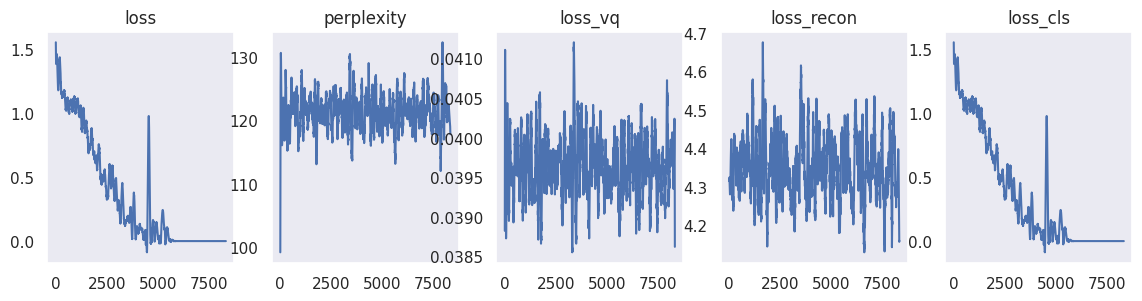

In [30]:
from scipy.signal import savgol_filter

fig, axes = plt.subplots(1, 5, figsize=(14,3))
for i, c in enumerate(loss_df.columns):
    axes[i].plot(savgol_filter(loss_df[c], 301, 7))
    axes[i].set_title(c)

In [20]:
from einops import reduce, repeat, rearrange

In [39]:
train_losses = reduce(np.array(trainer.train_losses[:118*70]), '(n k) -> n', 'mean', n=70)

In [60]:
trainer.test_accuracy = [
    50/135, 
    72/135, 
    89/135,
    84/135, 
    92/135, 
    95/135, 
    95/135, 
    94/135
]

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

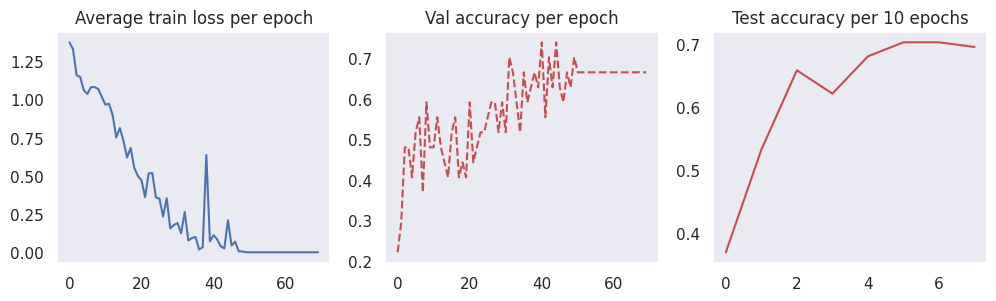

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

<Axes: xlabel='Predicted', ylabel='Actual'>

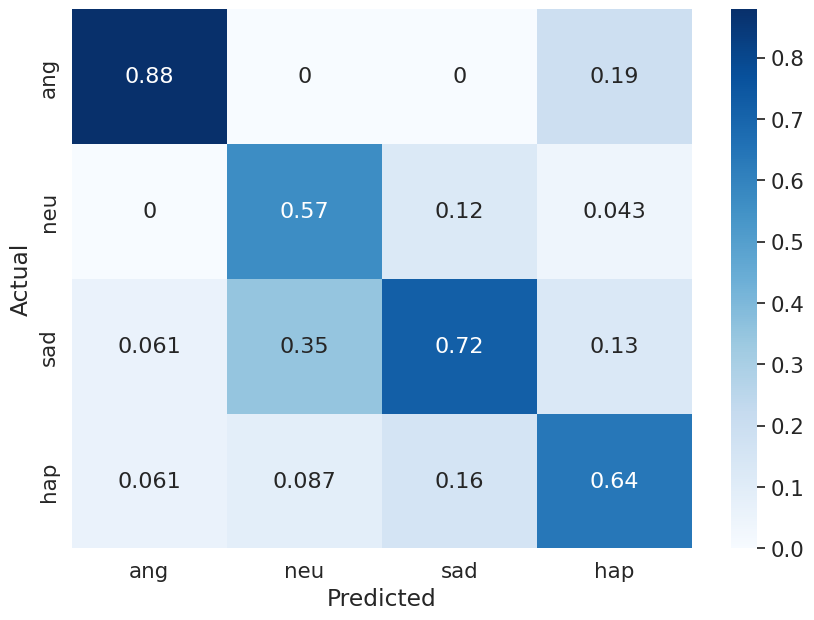

In [68]:
labels = dataset_config.target_labels
a = torch.tensor(
    [[29,  0,  0,  9],
        [ 0, 13,  4,  2],
        [ 2,  8, 23,  6],
        [ 2,  2,  5, 30]], dtype=torch.float)
# a /= reduce(a, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels )
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

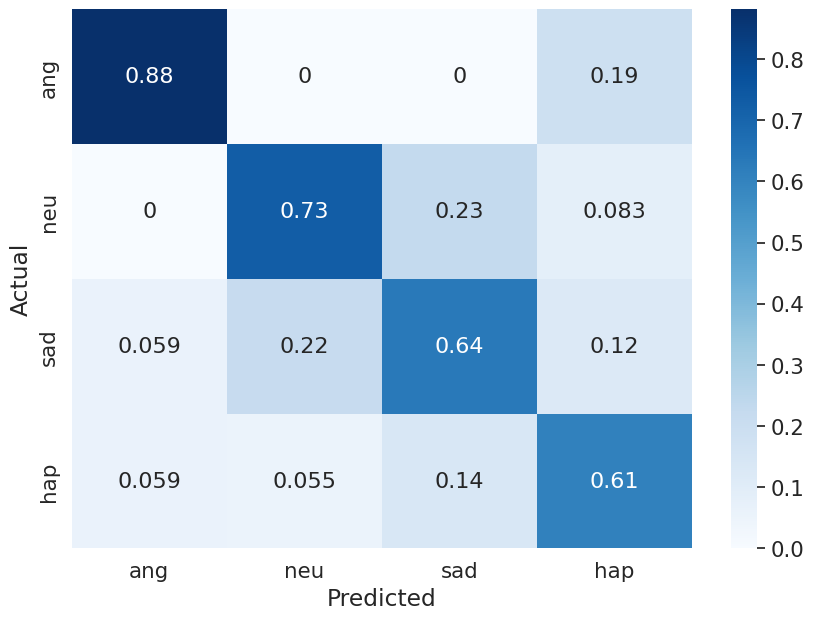

In [69]:
labels = dataset_config.target_labels
a = torch.tensor(
    [[29,  0,  0,  9],
        [ 0, 13,  4,  2],
        [ 2,  8, 23,  6],
        [ 2,  2,  5, 30]], dtype=torch.float)
a /= reduce(a, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels )
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [72]:
loss_df.to_csv(log_dir+"train_losses.csv")

In [8]:
dataset_name = 'meld'
experiment_prefix = "scb14"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"


In [9]:
dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)

{'name': 'meld', 'dataset_class': 'WaveformDataset', 'root': 'meld/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label_emotion_key', 'feature_name': 'audio16k', 'num_classes': 4, 'label_values': ['neu', 'hap', 'sad', 'ang'], 'classnames': ['neu', 'hap', 'sad', 'ang'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [11]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0, loss_recon=0, loss_cls=1)
batch_size = 2
trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=8)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [13]:
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.codebook.pt'
model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=512,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='minami',
    iconnet_config=iconnet_config,
)

In [14]:
trainer.setup(model=model, lr=learning_rate)

In [15]:
trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|▍                                                                               | 0.4768756423432689/100 [04:03<183:21:22, 6632.46s/it]

Epoch: 1	Loss: 1.339 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.339]	Val_acc: 42/184 (22.83%)

Saved new best val model: ../scb14_models/meld/model.epoch=1.step=406.loss=1.339.val_acc=0.228.pt


  1%|▊                                                                               | 0.9527235354573254/100 [08:08<180:32:22, 6561.94s/it]

Epoch: 1	Loss: 1.309 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.309]	Val_acc: 60/184 (32.61%)

Saved new best val model: ../scb14_models/meld/model.epoch=1.step=811.loss=1.309.val_acc=0.326.pt


  1%|█▏                                                                                  | 1.429599177800615/100 [10:10<7:05:33, 259.04s/it]

Correct: 248/928 (0.2672)
Saved new best test model: ../scb14_models/meld/model.epoch=1.step=811.test_acc=0.2672.pt
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2672, device='cuda:0'),
 'f1s_unweighted': tensor(0.1054, device='cuda:0'),
 'f1s_weighted': tensor(0.1127, device='cuda:0'),
 'rocauc': tensor(0.5377, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0714, device='cuda:0')}
{'acc_detail': tensor([0., 1., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.4218, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.2672, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0., 1., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.5806, 0.5235, 0.5453, 0.5015], device='cuda:0')}
tensor([[  0, 258,   0,   0],
        [  0, 248,   0,   0],
        [  0, 161,   0,   0],
        [  0, 261,   0,   0]], device='cuda:0')


  2%|█▌                                                                              | 1.9064748201439097/100 [14:15<183:15:23, 6725.45s/it]

Epoch: 2	Loss: 1.346 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.346]	Val_acc: 42/184 (22.83%)



  2%|█▉                                                                               | 2.382322713258016/100 [18:25<187:01:39, 6897.31s/it]

Epoch: 2	Loss: 1.414 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.414]	Val_acc: 42/184 (22.83%)



  3%|██▎                                                                             | 2.8591983556013107/100 [22:38<182:37:15, 6767.86s/it]

Epoch: 3	Loss: 1.481 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.481]	Val_acc: 42/184 (22.83%)



  3%|██▋                                                                             | 3.3350462487154173/100 [26:45<190:11:43, 7083.26s/it]

Epoch: 3	Loss: 1.521 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.521]	Val_acc: 33/184 (17.93%)



  4%|███                                                                              | 3.811921891058712/100 [31:12<189:14:01, 7082.39s/it]

Epoch: 4	Loss: 1.378 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.378]	Val_acc: 51/184 (27.72%)



  4%|███▍                                                                             | 4.287769784172694/100 [35:37<186:35:03, 7017.95s/it]

Epoch: 4	Loss: 1.292 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.292]	Val_acc: 60/184 (32.61%)



  5%|███▊                                                                            | 4.7646454265157825/100 [40:01<186:50:21, 7062.73s/it]

Epoch: 5	Loss: 1.304 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.304]	Val_acc: 61/184 (33.15%)

Saved new best val model: ../scb14_models/meld/model.epoch=5.step=3650.loss=1.304.val_acc=0.332.pt


  5%|████▏                                                                           | 5.2404933196296835/100 [44:28<184:36:15, 7013.28s/it]

Epoch: 5	Loss: 1.223 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.223]	Val_acc: 66/184 (35.87%)

Saved new best val model: ../scb14_models/meld/model.epoch=5.step=4055.loss=1.223.val_acc=0.359.pt


  6%|████▋                                                                            | 5.717368961972772/100 [48:56<184:12:17, 7033.50s/it]

Epoch: 6	Loss: 1.313 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.313]	Val_acc: 69/184 (37.50%)

Saved new best val model: ../scb14_models/meld/model.epoch=6.step=4461.loss=1.313.val_acc=0.375.pt


  6%|█████                                                                            | 6.193216855086673/100 [53:19<182:14:55, 6994.11s/it]

Epoch: 6	Loss: 1.364 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.364]	Val_acc: 67/184 (36.41%)



  7%|█████▍                                                                           | 6.670092497429762/100 [57:46<180:50:54, 6975.84s/it]

Epoch: 7	Loss: 1.233 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.233]	Val_acc: 72/184 (39.13%)

Saved new best val model: ../scb14_models/meld/model.epoch=7.step=5272.loss=1.233.val_acc=0.391.pt


  7%|█████▋                                                                         | 7.145940390543663/100 [1:02:12<182:26:05, 7073.09s/it]

Epoch: 7	Loss: 1.329 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.329]	Val_acc: 62/184 (33.70%)



  8%|██████                                                                         | 7.622816032886751/100 [1:06:40<179:12:00, 6983.55s/it]

Epoch: 8	Loss: 1.435 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.435]	Val_acc: 54/184 (29.35%)



  8%|██████▍                                                                        | 8.098663926000652/100 [1:11:06<182:29:06, 7148.38s/it]

Epoch: 8	Loss: 1.051 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.051]	Val_acc: 70/184 (38.04%)



  9%|██████▊                                                                        | 8.575539568343741/100 [1:15:32<179:18:04, 7060.31s/it]

Epoch: 9	Loss: 1.472 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.472]	Val_acc: 57/184 (30.98%)



  9%|███████▏                                                                       | 9.051387461457642/100 [1:19:59<177:55:29, 7042.76s/it]

Epoch: 9	Loss: 1.219 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.219]	Val_acc: 62/184 (33.70%)



 10%|███████▌                                                                        | 9.52826310380073/100 [1:24:25<176:50:33, 7036.82s/it]

Epoch: 10	Loss: 1.219 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.219]	Val_acc: 66/184 (35.87%)



 10%|███████▊                                                                      | 10.004110996914632/100 [1:28:52<177:16:28, 7091.30s/it]

Epoch: 10	Loss: 1.210 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.210]	Val_acc: 72/184 (39.13%)



 10%|████████▎                                                                      | 10.48098663925772/100 [1:33:18<175:03:43, 7040.10s/it]

Epoch: 11	Loss: 1.328 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.328]	Val_acc: 70/184 (38.04%)



 11%|████████▌                                                                     | 10.956834532371621/100 [1:37:44<176:34:44, 7139.06s/it]

Epoch: 11	Loss: 1.228 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.228]	Val_acc: 56/184 (30.43%)



 11%|█████████▍                                                                        | 11.43371017471471/100 [1:39:50<6:27:37, 262.60s/it]

Correct: 307/928 (0.3308)
Saved new best test model: ../scb14_models/meld/model.epoch=11.step=8921.test_acc=0.3308.pt
{'acc_unweighted': tensor(0.3001, device='cuda:0'),
 'acc_weighted': tensor(0.3308, device='cuda:0'),
 'f1s_unweighted': tensor(0.2292, device='cuda:0'),
 'f1s_weighted': tensor(0.2519, device='cuda:0'),
 'rocauc': tensor(0.6036, device='cuda:0'),
 'uar': tensor(0.3001, device='cuda:0'),
 'wap': tensor(0.2490, device='cuda:0')}
{'acc_detail': tensor([0.8295, 0.2903, 0.0000, 0.0805], device='cuda:0'),
 'f1s_detail': tensor([0.4880, 0.3097, 0.0000, 0.1190], device='cuda:0'),
 'precision_detail': tensor([0.3457, 0.3318, 0.0000, 0.2283], device='cuda:0'),
 'recall_detail': tensor([0.8295, 0.2903, 0.0000, 0.0805], device='cuda:0'),
 'rocauc_detail': tensor([0.6760, 0.6078, 0.6243, 0.5062], device='cuda:0')}
tensor([[214,  31,   0,  13],
        [135,  72,   0,  41],
        [ 83,  61,   0,  17],
        [187,  53,   0,  21]], device='cuda:0')


 12%|█████████▎                                                                    | 11.910585817057799/100 [1:44:17<172:48:06, 7061.99s/it]

Epoch: 12	Loss: 1.434 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.434]	Val_acc: 65/184 (35.33%)



 12%|█████████▉                                                                      | 12.3864337101717/100 [1:48:44<172:40:18, 7095.00s/it]

Epoch: 12	Loss: 1.304 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.304]	Val_acc: 70/184 (38.04%)



 13%|██████████                                                                    | 12.863309352514788/100 [1:53:10<173:26:06, 7165.37s/it]

Epoch: 13	Loss: 1.087 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.087]	Val_acc: 64/184 (34.78%)



 13%|██████████▍                                                                   | 13.339157245628689/100 [1:57:36<169:15:42, 7031.35s/it]

Epoch: 13	Loss: 0.742 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.742]	Val_acc: 65/184 (35.33%)



 14%|██████████▊                                                                   | 13.816032887971778/100 [2:02:06<170:27:49, 7120.46s/it]

Epoch: 14	Loss: 1.323 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.323]	Val_acc: 69/184 (37.50%)



 14%|███████████▏                                                                  | 14.291880781085679/100 [2:06:32<168:42:32, 7086.29s/it]

Epoch: 14	Loss: 1.352 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.352]	Val_acc: 47/184 (25.54%)



 15%|███████████▌                                                                  | 14.768756423428767/100 [2:11:01<167:10:17, 7061.00s/it]

Epoch: 15	Loss: 0.913 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.913]	Val_acc: 61/184 (33.15%)



 15%|███████████▉                                                                  | 15.244604316542668/100 [2:15:27<169:45:16, 7210.36s/it]

Epoch: 15	Loss: 1.420 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.420]	Val_acc: 72/184 (39.13%)



 16%|████████████▎                                                                 | 15.721479958885757/100 [2:19:56<169:26:23, 7237.71s/it]

Epoch: 16	Loss: 1.302 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.302]	Val_acc: 68/184 (36.96%)



 16%|████████████▊                                                                  | 16.19732785199966/100 [2:24:22<167:44:15, 7205.68s/it]

Epoch: 16	Loss: 1.298 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.298]	Val_acc: 60/184 (32.61%)



 17%|█████████████▏                                                                 | 16.67420349434275/100 [2:28:51<164:15:27, 7096.57s/it]

Epoch: 17	Loss: 0.934 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.934]	Val_acc: 67/184 (36.41%)



 17%|█████████████▌                                                                 | 17.15005138745665/100 [2:33:14<162:44:13, 7071.26s/it]

Epoch: 17	Loss: 1.526 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.526]	Val_acc: 55/184 (29.89%)



 18%|█████████████▋                                                                | 17.626927029799738/100 [2:37:42<163:19:58, 7138.24s/it]

Epoch: 18	Loss: 0.876 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.876]	Val_acc: 60/184 (32.61%)



 18%|██████████████▎                                                                | 18.10277492291364/100 [2:42:10<164:50:46, 7246.24s/it]

Epoch: 18	Loss: 0.723 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.723]	Val_acc: 60/184 (32.61%)



 19%|██████████████▍                                                               | 18.579650565256728/100 [2:46:39<160:53:00, 7113.46s/it]

Epoch: 19	Loss: 1.068 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.068]	Val_acc: 63/184 (34.24%)



 19%|███████████████                                                                | 19.05549845837063/100 [2:51:03<160:56:44, 7158.05s/it]

Epoch: 19	Loss: 0.929 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.929]	Val_acc: 65/184 (35.33%)



 20%|███████████████▏                                                              | 19.532374100713717/100 [2:55:34<160:23:17, 7175.52s/it]

Epoch: 20	Loss: 0.610 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.610]	Val_acc: 65/184 (35.33%)



 20%|███████████████▊                                                               | 20.00822199382762/100 [2:59:59<160:14:40, 7211.74s/it]

Epoch: 20	Loss: 1.076 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.076]	Val_acc: 66/184 (35.87%)



 20%|███████████████▉                                                              | 20.485097636170707/100 [3:04:28<158:02:46, 7155.47s/it]

Epoch: 21	Loss: 0.703 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.703]	Val_acc: 62/184 (33.70%)



 21%|████████████████▎                                                             | 20.960945529284608/100 [3:08:54<155:43:54, 7093.13s/it]

Epoch: 21	Loss: 1.617 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.617]	Val_acc: 51/184 (27.72%)



 21%|█████████████████▎                                                               | 21.437821171627697/100 [3:11:01<5:48:08, 265.89s/it]

Correct: 285/928 (0.3071)
{'acc_unweighted': tensor(0.3290, device='cuda:0'),
 'acc_weighted': tensor(0.3071, device='cuda:0'),
 'f1s_unweighted': tensor(0.2982, device='cuda:0'),
 'f1s_weighted': tensor(0.2979, device='cuda:0'),
 'rocauc': tensor(0.5922, device='cuda:0'),
 'uar': tensor(0.3290, device='cuda:0'),
 'wap': tensor(0.3431, device='cuda:0')}
{'acc_detail': tensor([0.3488, 0.1210, 0.5590, 0.2874], device='cuda:0'),
 'f1s_detail': tensor([0.3905, 0.1754, 0.3136, 0.3132], device='cuda:0'),
 'precision_detail': tensor([0.4433, 0.3191, 0.2179, 0.3440], device='cuda:0'),
 'recall_detail': tensor([0.3488, 0.1210, 0.5590, 0.2874], device='cuda:0'),
 'rocauc_detail': tensor([0.6019, 0.5918, 0.6208, 0.5540], device='cuda:0')}
tensor([[ 90,  18,  90,  60],
        [ 39,  30, 130,  49],
        [ 18,  19,  90,  34],
        [ 56,  27, 103,  75]], device='cuda:0')


 22%|█████████████████                                                             | 21.914696813970785/100 [3:15:26<154:33:40, 7125.80s/it]

Epoch: 22	Loss: 0.717 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.717]	Val_acc: 57/184 (30.98%)



 22%|█████████████████▍                                                            | 22.390544707084686/100 [3:19:54<153:12:40, 7106.87s/it]

Epoch: 22	Loss: 2.280 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.280]	Val_acc: 65/184 (35.33%)



 23%|█████████████████▊                                                            | 22.867420349427775/100 [3:24:23<154:07:47, 7193.68s/it]

Epoch: 23	Loss: 0.603 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.603]	Val_acc: 60/184 (32.61%)



 23%|██████████████████▏                                                           | 23.343268242541676/100 [3:28:50<153:22:18, 7202.73s/it]

Epoch: 23	Loss: 0.985 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.985]	Val_acc: 63/184 (34.24%)



 24%|██████████████████▌                                                           | 23.820143884884764/100 [3:33:16<151:22:07, 7153.17s/it]

Epoch: 24	Loss: 0.299 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.299]	Val_acc: 62/184 (33.70%)



 24%|██████████████████▉                                                           | 24.295991777998665/100 [3:37:47<149:07:02, 7091.07s/it]

Epoch: 24	Loss: 0.481 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.481]	Val_acc: 59/184 (32.07%)



 25%|███████████████████▎                                                          | 24.772867420341754/100 [3:42:18<148:41:20, 7115.52s/it]

Epoch: 25	Loss: 0.465 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.465]	Val_acc: 64/184 (34.78%)



 25%|███████████████████▋                                                          | 25.248715313455655/100 [3:46:42<148:11:18, 7136.71s/it]

Epoch: 25	Loss: 0.254 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.254]	Val_acc: 64/184 (34.78%)



 26%|████████████████████                                                          | 25.725590955798744/100 [3:51:11<147:42:18, 7159.10s/it]

Epoch: 26	Loss: 0.280 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.280]	Val_acc: 60/184 (32.61%)



 26%|████████████████████▍                                                         | 26.201438848912645/100 [3:55:37<146:41:02, 7155.46s/it]

Epoch: 26	Loss: 0.220 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.220]	Val_acc: 59/184 (32.07%)



 27%|████████████████████▊                                                         | 26.678314491255733/100 [4:00:10<145:51:34, 7161.52s/it]

Epoch: 27	Loss: 0.726 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.726]	Val_acc: 63/184 (34.24%)



 27%|█████████████████████▏                                                        | 27.154162384369634/100 [4:04:34<144:26:51, 7138.52s/it]

Epoch: 27	Loss: 0.437 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.437]	Val_acc: 63/184 (34.24%)



 28%|█████████████████████▌                                                        | 27.631038026712723/100 [4:09:06<144:02:18, 7165.20s/it]

Epoch: 28	Loss: 0.430 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.430]	Val_acc: 63/184 (34.24%)



 28%|█████████████████████▉                                                        | 28.106885919826624/100 [4:13:31<144:10:16, 7219.28s/it]

Epoch: 28	Loss: 0.559 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.559]	Val_acc: 62/184 (33.70%)



 29%|██████████████████████▎                                                       | 28.583761562169713/100 [4:17:58<141:17:10, 7122.06s/it]

Epoch: 29	Loss: 1.029 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.029]	Val_acc: 69/184 (37.50%)



 29%|██████████████████████▋                                                       | 29.059609455283613/100 [4:22:28<141:55:55, 7202.60s/it]

Epoch: 29	Loss: 0.479 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.479]	Val_acc: 66/184 (35.87%)



 30%|███████████████████████                                                       | 29.536485097626702/100 [4:26:47<140:38:50, 7185.71s/it]

Epoch: 30	Loss: 0.096 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.096]	Val_acc: 69/184 (37.50%)



 30%|███████████████████████▍                                                      | 30.012332990740603/100 [4:31:15<139:57:59, 7199.55s/it]

Epoch: 30	Loss: 0.286 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.286]	Val_acc: 73/184 (39.67%)

Saved new best val model: ../scb14_models/meld/model.epoch=30.step=24330.loss=0.286.val_acc=0.397.pt


 30%|███████████████████████▊                                                      | 30.489208633083692/100 [4:35:42<139:35:51, 7229.83s/it]

Epoch: 31	Loss: 0.471 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.471]	Val_acc: 65/184 (35.33%)



 31%|████████████████████████▏                                                     | 30.965056526197593/100 [4:40:13<138:04:21, 7200.14s/it]

Epoch: 31	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 57/184 (30.98%)



 31%|█████████████████████████▊                                                        | 31.44193216854068/100 [4:42:22<5:04:15, 266.28s/it]

Correct: 295/928 (0.3179)
{'acc_unweighted': tensor(0.3183, device='cuda:0'),
 'acc_weighted': tensor(0.3179, device='cuda:0'),
 'f1s_unweighted': tensor(0.3157, device='cuda:0'),
 'f1s_weighted': tensor(0.3193, device='cuda:0'),
 'rocauc': tensor(0.5683, device='cuda:0'),
 'uar': tensor(0.3183, device='cuda:0'),
 'wap': tensor(0.3299, device='cuda:0')}
{'acc_detail': tensor([0.2791, 0.3226, 0.3230, 0.3487], device='cuda:0'),
 'f1s_detail': tensor([0.3326, 0.3200, 0.2818, 0.3285], device='cuda:0'),
 'precision_detail': tensor([0.4114, 0.3175, 0.2500, 0.3106], device='cuda:0'),
 'recall_detail': tensor([0.2791, 0.3226, 0.3230, 0.3487], device='cuda:0'),
 'rocauc_detail': tensor([0.5680, 0.5590, 0.6080, 0.5383], device='cuda:0')}
tensor([[72, 56, 45, 85],
        [34, 80, 59, 75],
        [14, 53, 52, 42],
        [55, 63, 52, 91]], device='cuda:0')


 32%|█████████████████████████▏                                                     | 31.91880781088377/100 [4:46:50<137:51:17, 7289.50s/it]

Epoch: 32	Loss: 0.833 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.833]	Val_acc: 63/184 (34.24%)



 32%|█████████████████████████▌                                                     | 32.39465570399767/100 [4:51:18<134:56:25, 7185.61s/it]

Epoch: 32	Loss: 0.498 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.498]	Val_acc: 65/184 (35.33%)



 33%|█████████████████████████▉                                                     | 32.87153134634076/100 [4:55:49<136:10:44, 7303.07s/it]

Epoch: 33	Loss: 0.121 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.121]	Val_acc: 67/184 (36.41%)



 33%|██████████████████████████▎                                                    | 33.34737923945466/100 [5:00:16<133:58:17, 7235.99s/it]

Epoch: 33	Loss: 0.351 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.351]	Val_acc: 72/184 (39.13%)



 34%|██████████████████████████▋                                                    | 33.82425488179775/100 [5:04:45<132:39:52, 7217.04s/it]

Epoch: 34	Loss: 0.438 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.438]	Val_acc: 61/184 (33.15%)



 34%|███████████████████████████                                                    | 34.30010277491165/100 [5:09:16<132:32:22, 7262.46s/it]

Epoch: 34	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 69/184 (37.50%)



 35%|███████████████████████████▍                                                   | 34.77697841725474/100 [5:13:47<130:50:51, 7222.17s/it]

Epoch: 35	Loss: 0.057 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.057]	Val_acc: 65/184 (35.33%)



 35%|███████████████████████████▊                                                   | 35.25282631036864/100 [5:18:16<127:51:56, 7109.45s/it]

Epoch: 35	Loss: 0.360 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.360]	Val_acc: 59/184 (32.07%)



 36%|████████████████████████████▏                                                  | 35.72970195271173/100 [5:22:46<129:05:54, 7231.24s/it]

Epoch: 36	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 62/184 (33.70%)



 36%|████████████████████████████▌                                                  | 36.20554984582563/100 [5:27:15<127:47:50, 7211.76s/it]

Epoch: 36	Loss: 0.065 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.065]	Val_acc: 63/184 (34.24%)



 37%|████████████████████████████▉                                                  | 36.68242548816872/100 [5:31:44<128:59:19, 7333.81s/it]

Epoch: 37	Loss: 0.091 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.091]	Val_acc: 60/184 (32.61%)



 37%|█████████████████████████████▎                                                 | 37.15827338128262/100 [5:36:16<126:37:14, 7253.69s/it]

Epoch: 37	Loss: 0.285 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.285]	Val_acc: 61/184 (33.15%)



 38%|█████████████████████████████▋                                                 | 37.63514902362571/100 [5:40:51<126:34:41, 7306.70s/it]

Epoch: 38	Loss: 0.462 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.462]	Val_acc: 57/184 (30.98%)



 38%|██████████████████████████████                                                 | 38.11099691673961/100 [5:45:17<126:57:01, 7384.53s/it]

Epoch: 38	Loss: 0.481 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.481]	Val_acc: 62/184 (33.70%)



 39%|██████████████████████████████▊                                                 | 38.5878725590827/100 [5:49:44<124:15:37, 7284.18s/it]

Epoch: 39	Loss: 0.039 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.039]	Val_acc: 67/184 (36.41%)



 39%|███████████████████████████████▎                                                | 39.0637204521966/100 [5:54:15<121:55:43, 7203.33s/it]

Epoch: 39	Loss: 0.319 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.319]	Val_acc: 58/184 (31.52%)



 40%|███████████████████████████████▏                                               | 39.54059609453969/100 [5:58:41<120:01:06, 7146.38s/it]

Epoch: 40	Loss: 0.534 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.534]	Val_acc: 62/184 (33.70%)



 40%|███████████████████████████████▌                                               | 40.01644398765359/100 [6:03:14<119:39:07, 7181.09s/it]

Epoch: 40	Loss: 0.081 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.081]	Val_acc: 66/184 (35.87%)



 40%|███████████████████████████████▉                                               | 40.49331962999668/100 [6:07:48<121:23:11, 7343.57s/it]

Epoch: 41	Loss: 1.498 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.498]	Val_acc: 66/184 (35.87%)



 41%|████████████████████████████████▎                                              | 40.96916752311058/100 [6:12:15<120:00:58, 7319.19s/it]

Epoch: 41	Loss: 0.064 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.064]	Val_acc: 61/184 (33.15%)



 41%|█████████████████████████████████▌                                               | 41.446043165453666/100 [6:14:25<4:21:42, 268.18s/it]

Correct: 303/928 (0.3265)
{'acc_unweighted': tensor(0.3216, device='cuda:0'),
 'acc_weighted': tensor(0.3265, device='cuda:0'),
 'f1s_unweighted': tensor(0.3097, device='cuda:0'),
 'f1s_weighted': tensor(0.3145, device='cuda:0'),
 'rocauc': tensor(0.5822, device='cuda:0'),
 'uar': tensor(0.3216, device='cuda:0'),
 'wap': tensor(0.3345, device='cuda:0')}
{'acc_detail': tensor([0.3140, 0.1573, 0.2981, 0.5172], device='cuda:0'),
 'f1s_detail': tensor([0.3584, 0.2097, 0.2767, 0.3942], device='cuda:0'),
 'precision_detail': tensor([0.4175, 0.3145, 0.2581, 0.3184], device='cuda:0'),
 'recall_detail': tensor([0.3140, 0.1573, 0.2981, 0.5172], device='cuda:0'),
 'rocauc_detail': tensor([0.5929, 0.5589, 0.6223, 0.5548], device='cuda:0')}
tensor([[ 81,  27,  33, 117],
        [ 41,  39,  61, 107],
        [ 18,  30,  48,  65],
        [ 54,  28,  44, 135]], device='cuda:0')


 42%|████████████████████████████████▋                                             | 41.922918807796755/100 [6:18:43<115:04:04, 7132.68s/it]

Epoch: 42	Loss: 0.505 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.505]	Val_acc: 70/184 (38.04%)



 42%|█████████████████████████████████                                             | 42.398766700910656/100 [6:23:13<116:16:19, 7266.85s/it]

Epoch: 42	Loss: 0.301 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.301]	Val_acc: 69/184 (37.50%)



 43%|█████████████████████████████████▍                                            | 42.875642343253745/100 [6:27:46<117:05:40, 7379.34s/it]

Epoch: 43	Loss: 0.452 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.452]	Val_acc: 71/184 (38.59%)



 43%|█████████████████████████████████▊                                            | 43.351490236367646/100 [6:32:15<114:11:14, 7256.59s/it]

Epoch: 43	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 71/184 (38.59%)



 44%|██████████████████████████████████▏                                           | 43.828365878710734/100 [6:36:49<113:10:18, 7253.09s/it]

Epoch: 44	Loss: 0.076 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.076]	Val_acc: 72/184 (39.13%)



 44%|██████████████████████████████████▌                                           | 44.304213771824635/100 [6:41:18<112:15:10, 7255.68s/it]

Epoch: 44	Loss: 0.395 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.395]	Val_acc: 61/184 (33.15%)



 45%|██████████████████████████████████▉                                           | 44.781089414167724/100 [6:45:52<110:16:52, 7189.79s/it]

Epoch: 45	Loss: 0.223 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.223]	Val_acc: 66/184 (35.87%)



 45%|███████████████████████████████████▎                                          | 45.256937307281625/100 [6:50:17<111:02:07, 7301.88s/it]

Epoch: 45	Loss: 0.017 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.017]	Val_acc: 69/184 (37.50%)



 46%|████████████████████████████████████▏                                          | 45.73381294962471/100 [6:54:49<111:01:02, 7364.85s/it]

Epoch: 46	Loss: 0.108 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.108]	Val_acc: 63/184 (34.24%)



 46%|████████████████████████████████████                                          | 46.209660842738614/100 [6:59:17<108:04:42, 7233.31s/it]

Epoch: 46	Loss: 0.397 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.397]	Val_acc: 65/184 (35.33%)



 47%|█████████████████████████████████████▎                                          | 46.6865364850817/100 [7:03:50<106:57:02, 7221.86s/it]

Epoch: 47	Loss: 0.224 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.224]	Val_acc: 63/184 (34.24%)



 47%|████████████████████████████████████▊                                         | 47.162384378195604/100 [7:08:19<106:38:38, 7266.00s/it]

Epoch: 47	Loss: 0.205 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.205]	Val_acc: 69/184 (37.50%)



 48%|█████████████████████████████████████▋                                         | 47.63926002053869/100 [7:12:51<104:50:32, 7208.31s/it]

Epoch: 48	Loss: 0.116 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.116]	Val_acc: 63/184 (34.24%)



 48%|█████████████████████████████████████▌                                        | 48.115107913652594/100 [7:17:19<105:13:05, 7300.51s/it]

Epoch: 48	Loss: 0.066 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.066]	Val_acc: 59/184 (32.07%)



 49%|██████████████████████████████████████▍                                        | 48.59198355599568/100 [7:21:50<103:21:37, 7238.13s/it]

Epoch: 49	Loss: 0.050 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.050]	Val_acc: 64/184 (34.78%)



 49%|██████████████████████████████████████▊                                        | 49.06783144910958/100 [7:26:20<102:55:25, 7274.88s/it]

Epoch: 49	Loss: 0.092 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.092]	Val_acc: 62/184 (33.70%)



 50%|███████████████████████████████████████▏                                       | 49.54470709145267/100 [7:30:53<103:22:12, 7375.49s/it]

Epoch: 50	Loss: 0.065 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.065]	Val_acc: 70/184 (38.04%)



 50%|███████████████████████████████████████▌                                       | 50.02055498456657/100 [7:35:23<100:57:11, 7271.62s/it]

Epoch: 50	Loss: 0.184 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.184]	Val_acc: 73/184 (39.67%)



 50%|███████████████████████████████████████▉                                       | 50.49743062690966/100 [7:39:54<100:11:37, 7286.44s/it]

Epoch: 51	Loss: 0.266 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.266]	Val_acc: 57/184 (30.98%)



 51%|████████████████████████████████████████▎                                      | 50.97327852002356/100 [7:44:24<100:05:43, 7349.95s/it]

Epoch: 51	Loss: 0.300 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.300]	Val_acc: 63/184 (34.24%)



 51%|██████████████████████████████████████████▏                                       | 51.45015416236665/100 [7:46:36<3:44:43, 277.72s/it]

Correct: 314/928 (0.3384)
Saved new best test model: ../scb14_models/meld/model.epoch=51.step=41361.test_acc=0.3384.pt
{'acc_unweighted': tensor(0.3332, device='cuda:0'),
 'acc_weighted': tensor(0.3384, device='cuda:0'),
 'f1s_unweighted': tensor(0.3309, device='cuda:0'),
 'f1s_weighted': tensor(0.3372, device='cuda:0'),
 'rocauc': tensor(0.5799, device='cuda:0'),
 'uar': tensor(0.3332, device='cuda:0'),
 'wap': tensor(0.3566, device='cuda:0')}
{'acc_detail': tensor([0.2868, 0.2944, 0.2919, 0.4598], device='cuda:0'),
 'f1s_detail': tensor([0.3532, 0.3223, 0.2733, 0.3750], device='cuda:0'),
 'precision_detail': tensor([0.4596, 0.3561, 0.2568, 0.3166], device='cuda:0'),
 'recall_detail': tensor([0.2868, 0.2944, 0.2919, 0.4598], device='cuda:0'),
 'rocauc_detail': tensor([0.5811, 0.5714, 0.6086, 0.5584], device='cuda:0')}
tensor([[ 74,  41,  37, 106],
        [ 28,  73,  46, 101],
        [ 13,  49,  47,  52],
        [ 46,  42,  53, 120]], device='cuda:0')


 52%|█████████████████████████████████████████▌                                      | 51.92702980470974/100 [7:51:10<96:36:32, 7234.68s/it]

Epoch: 52	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 64/184 (34.78%)



 52%|█████████████████████████████████████████▉                                      | 52.40287769782364/100 [7:55:39<98:01:21, 7413.93s/it]

Epoch: 52	Loss: 0.456 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.456]	Val_acc: 68/184 (36.96%)



 53%|██████████████████████████████████████████▎                                     | 52.87975334016673/100 [8:00:09<94:51:00, 7246.57s/it]

Epoch: 53	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 63/184 (34.24%)



 53%|██████████████████████████████████████████▋                                     | 53.35560123328063/100 [8:04:42<94:50:00, 7319.22s/it]

Epoch: 53	Loss: 0.409 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.409]	Val_acc: 70/184 (38.04%)



 54%|███████████████████████████████████████████                                     | 53.83247687562372/100 [8:09:16<93:31:05, 7292.25s/it]

Epoch: 54	Loss: 0.054 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.054]	Val_acc: 63/184 (34.24%)



 54%|███████████████████████████████████████████▍                                    | 54.30832476873762/100 [8:13:43<94:05:08, 7412.90s/it]

Epoch: 54	Loss: 0.797 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.797]	Val_acc: 57/184 (30.98%)



 55%|███████████████████████████████████████████▊                                    | 54.78520041108071/100 [8:18:15<91:13:50, 7263.79s/it]

Epoch: 55	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 56/184 (30.43%)



 55%|████████████████████████████████████████████▏                                   | 55.26104830419461/100 [8:22:46<90:44:48, 7302.11s/it]

Epoch: 55	Loss: 0.043 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.043]	Val_acc: 63/184 (34.24%)



 56%|█████████████████████████████████████████████▏                                   | 55.7379239465377/100 [8:27:19<90:23:39, 7352.11s/it]

Epoch: 56	Loss: 0.012 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.012]	Val_acc: 62/184 (33.70%)



 56%|█████████████████████████████████████████████▌                                   | 56.2137718396516/100 [8:31:49<89:27:44, 7355.38s/it]

Epoch: 56	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 65/184 (35.33%)



 57%|█████████████████████████████████████████████▎                                  | 56.69064748199469/100 [8:36:19<87:31:29, 7275.32s/it]

Epoch: 57	Loss: 0.050 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.050]	Val_acc: 63/184 (34.24%)



 57%|█████████████████████████████████████████████▋                                  | 57.16649537510859/100 [8:40:50<87:31:28, 7356.12s/it]

Epoch: 57	Loss: 0.155 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.155]	Val_acc: 60/184 (32.61%)



 58%|██████████████████████████████████████████████                                  | 57.64337101745168/100 [8:45:20<86:12:57, 7327.71s/it]

Epoch: 58	Loss: 0.041 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.041]	Val_acc: 67/184 (36.41%)



 58%|██████████████████████████████████████████████▍                                 | 58.11921891056558/100 [8:49:53<85:37:57, 7360.84s/it]

Epoch: 58	Loss: 0.017 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.017]	Val_acc: 60/184 (32.61%)



 59%|██████████████████████████████████████████████▉                                 | 58.59609455290867/100 [8:54:25<84:46:16, 7370.72s/it]

Epoch: 59	Loss: 0.037 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.037]	Val_acc: 54/184 (29.35%)



 59%|███████████████████████████████████████████████▎                                | 59.07194244602257/100 [8:58:57<84:29:49, 7432.30s/it]

Epoch: 59	Loss: 1.285 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.285]	Val_acc: 68/184 (36.96%)



 60%|███████████████████████████████████████████████▋                                | 59.54881808836566/100 [9:03:33<81:49:51, 7282.65s/it]

Epoch: 60	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 71/184 (38.59%)



 60%|████████████████████████████████████████████████                                | 60.02466598147956/100 [9:08:00<80:48:58, 7277.94s/it]

Epoch: 60	Loss: 0.014 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.014]	Val_acc: 60/184 (32.61%)



 61%|███████████████████████████████████████████████▊                               | 60.501541623822646/100 [9:12:32<79:38:19, 7258.50s/it]

Epoch: 61	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 66/184 (35.87%)



 61%|████████████████████████████████████████████████▊                               | 60.97738951693655/100 [9:17:01<79:29:59, 7334.20s/it]

Epoch: 61	Loss: 0.797 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.797]	Val_acc: 62/184 (33.70%)



 61%|█████████████████████████████████████████████████▊                               | 61.454265159279636/100 [9:19:14<2:55:47, 273.65s/it]

Correct: 309/928 (0.3330)
{'acc_unweighted': tensor(0.3073, device='cuda:0'),
 'acc_weighted': tensor(0.3330, device='cuda:0'),
 'f1s_unweighted': tensor(0.2918, device='cuda:0'),
 'f1s_weighted': tensor(0.3113, device='cuda:0'),
 'rocauc': tensor(0.5695, device='cuda:0'),
 'uar': tensor(0.3073, device='cuda:0'),
 'wap': tensor(0.3473, device='cuda:0')}
{'acc_detail': tensor([0.2674, 0.3710, 0.0621, 0.5287], device='cuda:0'),
 'f1s_detail': tensor([0.3350, 0.3370, 0.1031, 0.3920], device='cuda:0'),
 'precision_detail': tensor([0.4481, 0.3087, 0.3030, 0.3115], device='cuda:0'),
 'recall_detail': tensor([0.2674, 0.3710, 0.0621, 0.5287], device='cuda:0'),
 'rocauc_detail': tensor([0.5822, 0.5516, 0.5866, 0.5576], device='cuda:0')}
tensor([[ 69,  63,   6, 120],
        [ 27,  92,  10, 119],
        [ 16,  69,  10,  66],
        [ 42,  74,   7, 138]], device='cuda:0')


 62%|████████████████████████████████████████████████▉                              | 61.931140801622725/100 [9:23:49<77:56:10, 7370.09s/it]

Epoch: 62	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 66/184 (35.87%)



 62%|█████████████████████████████████████████████████▎                             | 62.406988694736626/100 [9:28:19<77:06:56, 7384.78s/it]

Epoch: 62	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 57/184 (30.98%)



 63%|█████████████████████████████████████████████████▋                             | 62.883864337079714/100 [9:32:54<74:14:20, 7200.67s/it]

Epoch: 63	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 58/184 (31.52%)



 63%|██████████████████████████████████████████████████                             | 63.359712230193615/100 [9:37:26<74:48:14, 7349.69s/it]

Epoch: 63	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 64/184 (34.78%)



 64%|██████████████████████████████████████████████████▍                            | 63.836587872536704/100 [9:41:59<74:40:37, 7433.95s/it]

Epoch: 64	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 64/184 (34.78%)



 64%|███████████████████████████████████████████████████▍                            | 64.31243576565276/100 [9:46:31<73:42:04, 7434.65s/it]

Epoch: 64	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 57/184 (30.98%)



 65%|███████████████████████████████████████████████████▊                            | 64.78931140799915/100 [9:51:05<71:28:04, 7307.01s/it]

Epoch: 65	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 65/184 (35.33%)



 65%|████████████████████████████████████████████████████▏                           | 65.26515930111634/100 [9:55:37<71:15:13, 7384.89s/it]

Epoch: 65	Loss: 2.343 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.343]	Val_acc: 65/184 (35.33%)



 66%|███████████████████████████████████████████████████▉                           | 65.74203494346273/100 [10:00:13<70:07:47, 7369.60s/it]

Epoch: 66	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 64/184 (34.78%)



 66%|████████████████████████████████████████████████████▎                          | 66.21788283657992/100 [10:04:42<69:24:47, 7397.02s/it]

Epoch: 66	Loss: 0.054 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.054]	Val_acc: 60/184 (32.61%)



 67%|█████████████████████████████████████████████████████▎                          | 66.6947584789263/100 [10:09:15<69:07:50, 7472.41s/it]

Epoch: 67	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 60/184 (32.61%)



 67%|█████████████████████████████████████████████████████▋                          | 67.1706063720435/100 [10:13:47<67:07:57, 7361.63s/it]

Epoch: 67	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 64/184 (34.78%)



 68%|█████████████████████████████████████████████████████▍                         | 67.64748201438988/100 [10:18:23<65:42:19, 7311.32s/it]

Epoch: 68	Loss: 0.110 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.110]	Val_acc: 58/184 (31.52%)



 68%|█████████████████████████████████████████████████████▊                         | 68.12332990750707/100 [10:22:55<65:59:47, 7453.34s/it]

Epoch: 68	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 55/184 (29.89%)



 69%|██████████████████████████████████████████████████████▏                        | 68.60020554985346/100 [10:27:27<64:22:16, 7380.21s/it]

Epoch: 69	Loss: 0.120 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.120]	Val_acc: 61/184 (33.15%)



 69%|██████████████████████████████████████████████████████▌                        | 69.07605344297065/100 [10:31:58<63:52:51, 7436.69s/it]

Epoch: 69	Loss: 0.157 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.157]	Val_acc: 60/184 (32.61%)



 70%|██████████████████████████████████████████████████████▉                        | 69.55292908531703/100 [10:36:31<62:20:40, 7371.51s/it]

Epoch: 70	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 60/184 (32.61%)



 70%|███████████████████████████████████████████████████████▎                       | 70.02877697843422/100 [10:41:05<61:12:12, 7351.47s/it]

Epoch: 70	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 61/184 (33.15%)



 71%|███████████████████████████████████████████████████████▋                       | 70.50565262078061/100 [10:45:39<60:52:55, 7431.12s/it]

Epoch: 71	Loss: 0.032 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.032]	Val_acc: 66/184 (35.87%)



 71%|████████████████████████████████████████████████████████▊                       | 70.9815005138978/100 [10:50:10<59:08:49, 7337.73s/it]

Epoch: 71	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 64/184 (34.78%)



 71%|█████████████████████████████████████████████████████████▉                       | 71.45837615624419/100 [10:52:25<2:12:16, 278.07s/it]

Correct: 315/928 (0.3394)
Saved new best test model: ../scb14_models/meld/model.epoch=71.step=57581.test_acc=0.3394.pt
{'acc_unweighted': tensor(0.3147, device='cuda:0'),
 'acc_weighted': tensor(0.3394, device='cuda:0'),
 'f1s_unweighted': tensor(0.3023, device='cuda:0'),
 'f1s_weighted': tensor(0.3201, device='cuda:0'),
 'rocauc': tensor(0.5847, device='cuda:0'),
 'uar': tensor(0.3147, device='cuda:0'),
 'wap': tensor(0.3328, device='cuda:0')}
{'acc_detail': tensor([0.4612, 0.2218, 0.0932, 0.4828], device='cuda:0'),
 'f1s_detail': tensor([0.4304, 0.2644, 0.1382, 0.3761], device='cuda:0'),
 'precision_detail': tensor([0.4034, 0.3274, 0.2679, 0.3081], device='cuda:0'),
 'recall_detail': tensor([0.4612, 0.2218, 0.0932, 0.4828], device='cuda:0'),
 'rocauc_detail': tensor([0.6210, 0.5566, 0.6065, 0.5546], device='cuda:0')}
tensor([[119,  36,   8,  95],
        [ 64,  55,  16, 113],
        [ 30,  41,  15,  75],
        [ 82,  36,  17, 126]], device='cuda:0')


 72%|████████████████████████████████████████████████████████▊                      | 71.93525179859057/100 [10:57:00<57:54:31, 7428.22s/it]

Epoch: 72	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 63/184 (34.24%)



 72%|█████████████████████████████████████████████████████████▏                     | 72.41109969170776/100 [11:01:31<56:48:43, 7413.26s/it]

Epoch: 72	Loss: 0.107 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.107]	Val_acc: 60/184 (32.61%)



 73%|█████████████████████████████████████████████████████████▌                     | 72.88797533405415/100 [11:06:10<56:04:46, 7446.39s/it]

Epoch: 73	Loss: 0.043 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.043]	Val_acc: 58/184 (31.52%)



 73%|█████████████████████████████████████████████████████████▉                     | 73.36382322717134/100 [11:10:41<55:16:10, 7469.95s/it]

Epoch: 73	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 66/184 (35.87%)



 74%|██████████████████████████████████████████████████████████▎                    | 73.84069886951772/100 [11:15:10<53:15:25, 7329.17s/it]

Epoch: 74	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 59/184 (32.07%)



 74%|██████████████████████████████████████████████████████████▋                    | 74.31654676263491/100 [11:19:47<53:23:00, 7482.65s/it]

Epoch: 74	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 60/184 (32.61%)



 75%|███████████████████████████████████████████████████████████▊                    | 74.7934224049813/100 [11:24:19<52:09:40, 7449.67s/it]

Epoch: 75	Loss: 0.069 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.069]	Val_acc: 66/184 (35.87%)



 75%|███████████████████████████████████████████████████████████▍                   | 75.26927029809849/100 [11:28:55<51:02:46, 7430.70s/it]

Epoch: 75	Loss: 0.023 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.023]	Val_acc: 63/184 (34.24%)



 76%|███████████████████████████████████████████████████████████▊                   | 75.74614594044488/100 [11:33:30<49:29:55, 7347.09s/it]

Epoch: 76	Loss: 1.246 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.246]	Val_acc: 63/184 (34.24%)



 76%|████████████████████████████████████████████████████████████▏                  | 76.22199383356207/100 [11:38:04<49:48:28, 7540.93s/it]

Epoch: 76	Loss: 0.034 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.034]	Val_acc: 60/184 (32.61%)



 77%|████████████████████████████████████████████████████████████▌                  | 76.69886947590845/100 [11:42:39<47:56:06, 7405.94s/it]

Epoch: 77	Loss: 0.047 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.047]	Val_acc: 67/184 (36.41%)



 77%|████████████████████████████████████████████████████████████▉                  | 77.17471736902564/100 [11:47:12<47:11:32, 7443.17s/it]

Epoch: 77	Loss: 0.039 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.039]	Val_acc: 53/184 (28.80%)



 78%|█████████████████████████████████████████████████████████████▎                 | 77.65159301137203/100 [11:51:45<45:46:23, 7373.39s/it]

Epoch: 78	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 61/184 (33.15%)



 78%|█████████████████████████████████████████████████████████████▋                 | 78.12744090448922/100 [11:56:22<45:25:58, 7477.79s/it]

Epoch: 78	Loss: 0.092 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.092]	Val_acc: 66/184 (35.87%)



 79%|██████████████████████████████████████████████████████████████▉                 | 78.6043165468356/100 [12:00:54<45:09:34, 7598.47s/it]

Epoch: 79	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 67/184 (36.41%)



 79%|███████████████████████████████████████████████████████████████▎                | 79.0801644399528/100 [12:05:32<43:18:50, 7453.72s/it]

Epoch: 79	Loss: 0.023 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.023]	Val_acc: 61/184 (33.15%)



 80%|██████████████████████████████████████████████████████████████▊                | 79.55704008229918/100 [12:10:05<41:51:23, 7370.93s/it]

Epoch: 80	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 63/184 (34.24%)



 80%|███████████████████████████████████████████████████████████████▏               | 80.03288797541637/100 [12:14:40<41:29:19, 7480.26s/it]

Epoch: 80	Loss: 1.611 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.611]	Val_acc: 64/184 (34.78%)



 81%|███████████████████████████████████████████████████████████████▌               | 80.50976361776276/100 [12:19:11<40:43:31, 7522.33s/it]

Epoch: 81	Loss: 0.010 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.010]	Val_acc: 63/184 (34.24%)



 81%|███████████████████████████████████████████████████████████████▉               | 80.98561151087995/100 [12:23:48<40:06:21, 7593.30s/it]

Epoch: 81	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 62/184 (33.70%)



 81%|█████████████████████████████████████████████████████████████████▉               | 81.46248715322633/100 [12:26:05<1:27:32, 283.32s/it]

Correct: 316/928 (0.3405)
Saved new best test model: ../scb14_models/meld/model.epoch=81.step=65691.test_acc=0.3405.pt
{'acc_unweighted': tensor(0.3357, device='cuda:0'),
 'acc_weighted': tensor(0.3405, device='cuda:0'),
 'f1s_unweighted': tensor(0.3299, device='cuda:0'),
 'f1s_weighted': tensor(0.3355, device='cuda:0'),
 'rocauc': tensor(0.5799, device='cuda:0'),
 'uar': tensor(0.3357, device='cuda:0'),
 'wap': tensor(0.3405, device='cuda:0')}
{'acc_detail': tensor([0.4380, 0.2097, 0.3043, 0.3908], device='cuda:0'),
 'f1s_detail': tensor([0.4170, 0.2581, 0.2841, 0.3604], device='cuda:0'),
 'precision_detail': tensor([0.3979, 0.3355, 0.2663, 0.3344], device='cuda:0'),
 'recall_detail': tensor([0.4380, 0.2097, 0.3043, 0.3908], device='cuda:0'),
 'rocauc_detail': tensor([0.6105, 0.5455, 0.6106, 0.5531], device='cuda:0')}
tensor([[113,  34,  31,  80],
        [ 62,  52,  59,  75],
        [ 30,  34,  49,  48],
        [ 79,  35,  45, 102]], device='cuda:0')


 82%|████████████████████████████████████████████████████████████████▋              | 81.93936279557272/100 [12:30:42<37:38:55, 7504.49s/it]

Epoch: 82	Loss: 0.019 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.019]	Val_acc: 66/184 (35.87%)



 82%|█████████████████████████████████████████████████████████████████              | 82.41521068868991/100 [12:35:14<36:39:12, 7503.78s/it]

Epoch: 82	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 73/184 (39.67%)



 83%|██████████████████████████████████████████████████████████████████▎             | 82.8920863310363/100 [12:39:37<34:35:23, 7278.73s/it]

Epoch: 83	Loss: 1.538 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.538]	Val_acc: 62/184 (33.70%)



 83%|█████████████████████████████████████████████████████████████████▊             | 83.36793422415349/100 [12:43:56<34:37:23, 7494.16s/it]

Epoch: 83	Loss: 0.076 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.076]	Val_acc: 68/184 (36.96%)



 84%|██████████████████████████████████████████████████████████████████▏            | 83.84480986649987/100 [12:48:17<32:04:20, 7146.96s/it]

Epoch: 84	Loss: 0.016 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.016]	Val_acc: 54/184 (29.35%)



 84%|██████████████████████████████████████████████████████████████████▌            | 84.32065775961706/100 [12:52:33<31:49:54, 7308.64s/it]

Epoch: 84	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 61/184 (33.15%)



 85%|██████████████████████████████████████████████████████████████████▉            | 84.79753340196345/100 [12:56:55<29:59:56, 7103.89s/it]

Epoch: 85	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 65/184 (35.33%)



 85%|███████████████████████████████████████████████████████████████████▎           | 85.27338129508064/100 [13:01:11<29:48:03, 7285.03s/it]

Epoch: 85	Loss: 0.038 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.038]	Val_acc: 63/184 (34.24%)



 86%|███████████████████████████████████████████████████████████████████▋           | 85.75025693742703/100 [13:05:30<28:12:27, 7126.27s/it]

Epoch: 86	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 66/184 (35.87%)



 86%|████████████████████████████████████████████████████████████████████           | 86.22610483054422/100 [13:09:47<27:37:50, 7221.64s/it]

Epoch: 86	Loss: 0.076 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.076]	Val_acc: 65/184 (35.33%)



 87%|█████████████████████████████████████████████████████████████████████▎          | 86.7029804728906/100 [13:14:10<26:20:38, 7132.34s/it]

Epoch: 87	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 62/184 (33.70%)



 87%|██████████████████████████████████████████████████████████████████████▏          | 86.72456320670369/100 [13:14:20<1:41:37, 459.29s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x78f8cad71070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 87%|██████████████████████████████████████████████████████████████████████▏          | 86.72456320670369/100 [13:14:21<2:01:35, 549.57s/it]


KeyboardInterrupt: 

In [16]:
trainer.load_best_model(val_model=True)

Loaded: ../scb14_models/meld/model.epoch=30.step=24330.loss=0.286.val_acc=0.397.pt


In [17]:
from pprint import pprint

In [18]:
metrics, metrics_details, confusion_matrix = trainer.test_step()
pprint(metrics.compute())
pprint(metrics_details.compute())
pprint(confusion_matrix.compute())

Correct: 321/928 (0.3459)
Saved new best test model: ../scb14_models/meld/model.epoch=87.step=70171.test_acc=0.3459.pt
{'acc_unweighted': tensor(0.3170, device='cuda:0'),
 'acc_weighted': tensor(0.3459, device='cuda:0'),
 'f1s_unweighted': tensor(0.2970, device='cuda:0'),
 'f1s_weighted': tensor(0.3200, device='cuda:0'),
 'rocauc': tensor(0.5867, device='cuda:0'),
 'uar': tensor(0.3170, device='cuda:0'),
 'wap': tensor(0.3395, device='cuda:0')}
{'acc_detail': tensor([0.5271, 0.3105, 0.0435, 0.3870], device='cuda:0'),
 'f1s_detail': tensor([0.4324, 0.3202, 0.0765, 0.3588], device='cuda:0'),
 'precision_detail': tensor([0.3666, 0.3305, 0.3182, 0.3344], device='cuda:0'),
 'recall_detail': tensor([0.5271, 0.3105, 0.0435, 0.3870], device='cuda:0'),
 'rocauc_detail': tensor([0.6060, 0.5729, 0.6204, 0.5476], device='cuda:0')}
tensor([[136,  45,   4,  73],
        [ 83,  77,   8,  80],
        [ 46,  60,   7,  48],
        [106,  51,   3, 101]], device='cuda:0')


In [9]:
# iconnet_config.fe.n_channel = [256]
# iconnet_config.fe.mel_resolution = 4
# iconnet_config.cls.n_hidden_dim = 512, 512
# iconnet_config.cls.dropout = 0.1
# print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [456], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 4, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.1}}


In [8]:
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.codebook.pt'
model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=512,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='minami',
    iconnet_config=iconnet_config,
)

In [9]:
dataset_name = 'crema_d'
experiment_prefix = "scb14"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"
dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
batch_size = 2

{'name': 'crema_d', 'dataset_class': 'WaveformDataset', 'root': 'crema_d/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label6', 'feature_name': 'audio16k', 'num_classes': 6, 'label_values': ['neu', 'hap', 'sad', 'ang', 'fea', 'dis'], 'classnames': ['neu', 'hap', 'sad', 'ang', 'fea', 'dis'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [10]:
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)

In [11]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=1, loss_cls=0.1)
trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=8)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [12]:
trainer.setup(model=model, lr=learning_rate)

In [13]:
trainer.fit(
    n_epoch=500, lr=learning_rate, self_supervised=False, 
    train_task='embedding', test_n_epoch=10)

  0%|                         | 0.47667638483965535/500 [05:33<3127:35:43, 22540.18s/it]

Epoch: 1	Loss: 6.323 [perplexity=129.756, loss_vq=0.059, loss_recon=6.173, loss_cls=0.909]	Val_acc: 119/196 (60.71%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=1.step=858.loss=6.323.val_acc=0.607.pt


  0%|                               | 1.428571428571466/500 [14:34<71:45:25, 518.13s/it]

Correct: 392/980 (0.4000)
Saved new best test model: ../scb14_models/crema_d/model.epoch=1.step=1715.test_acc=0.4000.pt
{'acc_unweighted': tensor(0.4209, device='cuda:0'),
 'acc_weighted': tensor(0.4000, device='cuda:0'),
 'f1s_unweighted': tensor(0.2863, device='cuda:0'),
 'f1s_weighted': tensor(0.2799, device='cuda:0'),
 'rocauc': tensor(0.8065, device='cuda:0'),
 'uar': tensor(0.4209, device='cuda:0'),
 'wap': tensor(0.2422, device='cuda:0')}
{'acc_detail': tensor([0.6929, 0.9908, 0.0000, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.6848, 0.4606, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.6769, 0.3000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.6929, 0.9908, 0.0000, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.9053, 0.7174, 0.9043, 0.6988], device='cuda:0')}
tensor([[176,  78,   0,   0],
        [  2, 216,   0,   0],
        [  2, 252,   0,   0],
        [ 80, 174,   0,   0]], device='cuda:0')


  0%|                          | 1.9052478134111321/500 [20:13<3120:52:49, 22556.29s/it]

Epoch: 2	Loss: 5.935 [perplexity=119.540, loss_vq=0.056, loss_recon=5.786, loss_cls=0.927]	Val_acc: 125/196 (63.78%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=2.step=2573.loss=5.935.val_acc=0.638.pt


  1%|▏                         | 2.8576287657921164/500 [30:54<3143:20:20, 22762.13s/it]

Epoch: 3	Loss: 4.600 [perplexity=106.884, loss_vq=0.052, loss_recon=4.413, loss_cls=1.354]	Val_acc: 117/196 (59.69%)



  1%|▏                          | 3.810009718173101/500 [41:34<3134:54:03, 22744.60s/it]

Epoch: 4	Loss: 6.115 [perplexity=93.264, loss_vq=0.050, loss_recon=5.979, loss_cls=0.863]	Val_acc: 126/196 (64.29%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=4.step=6003.loss=6.115.val_acc=0.643.pt


  1%|▎                          | 4.762390670554085/500 [52:16<3134:57:33, 22788.77s/it]

Epoch: 5	Loss: 4.770 [perplexity=69.498, loss_vq=0.041, loss_recon=4.638, loss_cls=0.908]	Val_acc: 126/196 (64.29%)



  1%|▎                         | 5.71477162293507/500 [1:02:52<3086:32:49, 22480.08s/it]

Epoch: 6	Loss: 7.153 [perplexity=86.517, loss_vq=0.053, loss_recon=7.062, loss_cls=0.380]	Val_acc: 119/196 (60.71%)



  1%|▎                        | 6.667152575316054/500 [1:13:34<3077:10:31, 22455.09s/it]

Epoch: 7	Loss: 4.210 [perplexity=117.777, loss_vq=0.056, loss_recon=4.076, loss_cls=0.782]	Val_acc: 113/196 (57.65%)



  2%|▍                        | 7.619533527697039/500 [1:24:15<3099:05:13, 22658.73s/it]

Epoch: 8	Loss: 5.642 [perplexity=107.528, loss_vq=0.052, loss_recon=5.535, loss_cls=0.553]	Val_acc: 120/196 (61.22%)



  2%|▍                        | 8.571914480076977/500 [1:35:00<3112:32:22, 22801.19s/it]

Epoch: 9	Loss: 4.994 [perplexity=127.019, loss_vq=0.056, loss_recon=4.778, loss_cls=1.596]	Val_acc: 114/196 (58.16%)



  2%|▍                         | 9.52429543245622/500 [1:45:47<3094:47:06, 22715.14s/it]

Epoch: 10	Loss: 4.025 [perplexity=106.929, loss_vq=0.055, loss_recon=3.521, loss_cls=4.480]	Val_acc: 120/196 (61.22%)



  2%|▌                       | 10.476676384835464/500 [1:56:29<3095:02:59, 22761.28s/it]

Epoch: 11	Loss: 6.639 [perplexity=93.648, loss_vq=0.052, loss_recon=6.491, loss_cls=0.967]	Val_acc: 119/196 (60.71%)



  2%|▋                           | 11.428571428565535/500 [2:05:48<72:18:42, 532.82s/it]

Correct: 613/980 (0.6255)
Saved new best test model: ../scb14_models/crema_d/model.epoch=11.step=18865.test_acc=0.6255.pt
{'acc_unweighted': tensor(0.6282, device='cuda:0'),
 'acc_weighted': tensor(0.6255, device='cuda:0'),
 'f1s_unweighted': tensor(0.6255, device='cuda:0'),
 'f1s_weighted': tensor(0.6262, device='cuda:0'),
 'rocauc': tensor(0.8576, device='cuda:0'),
 'uar': tensor(0.6282, device='cuda:0'),
 'wap': tensor(0.6469, device='cuda:0')}
{'acc_detail': tensor([0.7638, 0.7018, 0.5945, 0.4528], device='cuda:0'),
 'f1s_detail': tensor([0.7159, 0.6083, 0.7056, 0.4723], device='cuda:0'),
 'precision_detail': tensor([0.6736, 0.5368, 0.8678, 0.4936], device='cuda:0'),
 'recall_detail': tensor([0.7638, 0.7018, 0.5945, 0.4528], device='cuda:0'),
 'rocauc_detail': tensor([0.9150, 0.8530, 0.9099, 0.7525], device='cuda:0')}
tensor([[194,   7,   0,  53],
        [  2, 153,  19,  44],
        [  5,  77, 151,  21],
        [ 87,  48,   4, 115]], device='cuda:0')


  2%|▌                        | 11.90524781340433/500 [2:11:39<3178:25:37, 23442.86s/it]

Epoch: 12	Loss: 4.452 [perplexity=118.195, loss_vq=0.056, loss_recon=4.351, loss_cls=0.447]	Val_acc: 108/196 (55.10%)



  3%|▌                       | 12.857628765783573/500 [2:22:44<3195:35:10, 23615.50s/it]

Epoch: 13	Loss: 6.418 [perplexity=88.835, loss_vq=0.054, loss_recon=6.339, loss_cls=0.251]	Val_acc: 121/196 (61.73%)



  3%|▋                       | 13.810009718162817/500 [2:33:51<3178:42:47, 23536.82s/it]

Epoch: 14	Loss: 5.088 [perplexity=99.625, loss_vq=0.052, loss_recon=5.009, loss_cls=0.269]	Val_acc: 120/196 (61.22%)



  3%|▋                       | 14.762390670542061/500 [2:45:00<3149:43:31, 23367.96s/it]

Epoch: 15	Loss: 5.606 [perplexity=110.329, loss_vq=0.056, loss_recon=5.524, loss_cls=0.264]	Val_acc: 113/196 (57.65%)



  3%|▊                       | 15.714771622921305/500 [2:56:07<3176:42:06, 23614.44s/it]

Epoch: 16	Loss: 5.741 [perplexity=140.158, loss_vq=0.054, loss_recon=5.667, loss_cls=0.198]	Val_acc: 115/196 (58.67%)



  3%|▊                       | 16.667152575302985/500 [3:07:15<3216:45:27, 23959.32s/it]

Epoch: 17	Loss: 4.028 [perplexity=127.971, loss_vq=0.050, loss_recon=3.966, loss_cls=0.111]	Val_acc: 112/196 (57.14%)



  4%|▉                        | 17.61953352768571/500 [3:18:28<3218:56:55, 24022.98s/it]

Epoch: 18	Loss: 5.733 [perplexity=101.956, loss_vq=0.055, loss_recon=5.648, loss_cls=0.306]	Val_acc: 115/196 (58.67%)



  4%|▉                       | 18.571914480068436/500 [3:29:44<3184:08:13, 23810.19s/it]

Epoch: 19	Loss: 5.721 [perplexity=124.628, loss_vq=0.057, loss_recon=5.530, loss_cls=1.338]	Val_acc: 110/196 (56.12%)



  4%|▉                        | 19.52429543245116/500 [3:40:59<3155:55:22, 23645.99s/it]

Epoch: 20	Loss: 5.446 [perplexity=105.006, loss_vq=0.054, loss_recon=5.255, loss_cls=1.370]	Val_acc: 113/196 (57.65%)



  4%|▉                       | 20.476676384833887/500 [3:52:14<3189:59:18, 23948.70s/it]

Epoch: 21	Loss: 5.582 [perplexity=78.786, loss_vq=0.046, loss_recon=5.525, loss_cls=0.112]	Val_acc: 118/196 (60.20%)



  4%|█▏                          | 21.428571428567437/500 [4:01:55<72:25:04, 544.75s/it]

Correct: 598/980 (0.6102)
{'acc_unweighted': tensor(0.6138, device='cuda:0'),
 'acc_weighted': tensor(0.6102, device='cuda:0'),
 'f1s_unweighted': tensor(0.6148, device='cuda:0'),
 'f1s_weighted': tensor(0.6157, device='cuda:0'),
 'rocauc': tensor(0.8559, device='cuda:0'),
 'uar': tensor(0.6138, device='cuda:0'),
 'wap': tensor(0.6383, device='cuda:0')}
{'acc_detail': tensor([0.6024, 0.7110, 0.6220, 0.5197], device='cuda:0'),
 'f1s_detail': tensor([0.6638, 0.5916, 0.6991, 0.5048], device='cuda:0'),
 'precision_detail': tensor([0.7391, 0.5065, 0.7980, 0.4907], device='cuda:0'),
 'recall_detail': tensor([0.6024, 0.7110, 0.6220, 0.5197], device='cuda:0'),
 'rocauc_detail': tensor([0.9098, 0.8483, 0.9042, 0.7613], device='cuda:0')}
tensor([[153,   9,   2,  90],
        [  1, 155,  29,  33],
        [  4,  78, 158,  14],
        [ 49,  64,   9, 132]], device='cuda:0')


  4%|█                       | 21.905247813407975/500 [4:07:56<3232:05:47, 24337.33s/it]

Epoch: 22	Loss: 5.862 [perplexity=97.546, loss_vq=0.046, loss_recon=5.779, loss_cls=0.362]	Val_acc: 123/196 (62.76%)



  5%|█▏                        | 22.8576287657907/500 [4:19:16<3199:27:22, 24139.64s/it]

Epoch: 23	Loss: 4.000 [perplexity=118.970, loss_vq=0.052, loss_recon=3.944, loss_cls=0.040]	Val_acc: 119/196 (60.71%)



  5%|█▏                      | 23.810009718173426/500 [4:30:37<3209:49:30, 24266.30s/it]

Epoch: 24	Loss: 5.474 [perplexity=132.465, loss_vq=0.057, loss_recon=5.416, loss_cls=0.010]	Val_acc: 122/196 (62.24%)



  5%|█▏                       | 24.76239067055615/500 [4:41:59<3182:00:08, 24104.17s/it]

Epoch: 25	Loss: 6.648 [perplexity=98.964, loss_vq=0.051, loss_recon=6.597, loss_cls=0.002]	Val_acc: 122/196 (62.24%)



  5%|█▏                      | 25.714771622938876/500 [4:53:22<3194:37:48, 24248.42s/it]

Epoch: 26	Loss: 4.184 [perplexity=69.851, loss_vq=0.045, loss_recon=4.128, loss_cls=0.106]	Val_acc: 124/196 (63.27%)



  5%|█▍                        | 26.6671525753216/500 [5:04:47<3220:00:49, 24490.27s/it]

Epoch: 27	Loss: 3.097 [perplexity=105.413, loss_vq=0.049, loss_recon=3.023, loss_cls=0.257]	Val_acc: 111/196 (56.63%)



  6%|█▎                      | 27.619533527704327/500 [5:15:58<3203:24:52, 24413.14s/it]

Epoch: 28	Loss: 5.124 [perplexity=132.123, loss_vq=0.061, loss_recon=5.056, loss_cls=0.074]	Val_acc: 122/196 (62.24%)



  6%|█▎                      | 28.571914480087052/500 [5:27:12<3209:42:05, 24510.47s/it]

Epoch: 29	Loss: 7.089 [perplexity=98.026, loss_vq=0.056, loss_recon=6.961, loss_cls=0.714]	Val_acc: 120/196 (61.22%)



  6%|█▍                      | 29.524295432469778/500 [5:38:28<3206:53:53, 24538.64s/it]

Epoch: 30	Loss: 4.531 [perplexity=131.081, loss_vq=0.058, loss_recon=4.474, loss_cls=0.000]	Val_acc: 120/196 (61.22%)



  6%|█▍                      | 30.476676384852503/500 [5:49:42<3186:45:05, 24433.94s/it]

Epoch: 31	Loss: 4.559 [perplexity=159.653, loss_vq=0.057, loss_recon=4.490, loss_cls=0.120]	Val_acc: 119/196 (60.71%)



  6%|█▊                          | 31.428571428586054/500 [5:59:32<74:37:57, 573.40s/it]

Correct: 602/980 (0.6143)
{'acc_unweighted': tensor(0.6094, device='cuda:0'),
 'acc_weighted': tensor(0.6143, device='cuda:0'),
 'f1s_unweighted': tensor(0.6106, device='cuda:0'),
 'f1s_weighted': tensor(0.6142, device='cuda:0'),
 'rocauc': tensor(0.8530, device='cuda:0'),
 'uar': tensor(0.6094, device='cuda:0'),
 'wap': tensor(0.6165, device='cuda:0')}
{'acc_detail': tensor([0.6929, 0.4771, 0.7323, 0.5354], device='cuda:0'),
 'f1s_detail': tensor([0.7082, 0.5136, 0.7140, 0.5065], device='cuda:0'),
 'precision_detail': tensor([0.7243, 0.5561, 0.6966, 0.4806], device='cuda:0'),
 'recall_detail': tensor([0.6929, 0.4771, 0.7323, 0.5354], device='cuda:0'),
 'rocauc_detail': tensor([0.9095, 0.8527, 0.9019, 0.7479], device='cuda:0')}
tensor([[176,   3,   5,  70],
        [  1, 104,  57,  56],
        [  5,  42, 186,  21],
        [ 61,  38,  19, 136]], device='cuda:0')


  6%|█▌                       | 31.90524781342659/500 [6:05:32<3180:10:23, 24457.92s/it]

Epoch: 32	Loss: 5.959 [perplexity=65.597, loss_vq=0.050, loss_recon=5.908, loss_cls=0.013]	Val_acc: 114/196 (58.16%)



  7%|█▋                       | 32.85762876580932/500 [6:16:49<3179:38:51, 24503.73s/it]

Epoch: 33	Loss: 5.328 [perplexity=129.679, loss_vq=0.051, loss_recon=5.277, loss_cls=0.004]	Val_acc: 120/196 (61.22%)



  7%|█▋                       | 33.81000971819204/500 [6:28:07<3130:08:41, 24171.52s/it]

Epoch: 34	Loss: 3.802 [perplexity=80.399, loss_vq=0.045, loss_recon=3.756, loss_cls=0.017]	Val_acc: 123/196 (62.76%)



  7%|█▋                       | 34.76239067057477/500 [6:39:27<3177:47:51, 24589.74s/it]

Epoch: 35	Loss: 4.637 [perplexity=102.053, loss_vq=0.047, loss_recon=4.587, loss_cls=0.029]	Val_acc: 120/196 (61.22%)



  7%|█▊                       | 35.71477162295749/500 [6:50:49<3188:10:08, 24720.60s/it]

Epoch: 36	Loss: 4.733 [perplexity=66.696, loss_vq=0.042, loss_recon=4.691, loss_cls=0.000]	Val_acc: 127/196 (64.80%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=36.step=60883.loss=4.733.val_acc=0.648.pt


  7%|█▊                       | 36.66715257534022/500 [7:02:12<3158:31:35, 24541.09s/it]

Epoch: 37	Loss: 6.169 [perplexity=68.308, loss_vq=0.044, loss_recon=6.124, loss_cls=0.005]	Val_acc: 129/196 (65.82%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=37.step=62598.loss=6.169.val_acc=0.658.pt


  8%|█▉                       | 37.61953352772294/500 [7:13:38<3140:44:46, 24453.21s/it]

Epoch: 38	Loss: 4.109 [perplexity=139.716, loss_vq=0.052, loss_recon=4.056, loss_cls=0.004]	Val_acc: 121/196 (61.73%)



  8%|█▉                       | 38.57191448010567/500 [7:25:04<3128:01:22, 24404.42s/it]

Epoch: 39	Loss: 5.345 [perplexity=80.824, loss_vq=0.049, loss_recon=5.163, loss_cls=1.328]	Val_acc: 123/196 (62.76%)



  8%|█▉                      | 39.524295432488394/500 [7:36:32<3133:57:31, 24501.30s/it]

Epoch: 40	Loss: 6.014 [perplexity=114.142, loss_vq=0.054, loss_recon=5.959, loss_cls=0.006]	Val_acc: 128/196 (65.31%)



  8%|██                       | 40.47667638487112/500 [7:47:59<3161:53:52, 24770.96s/it]

Epoch: 41	Loss: 8.094 [perplexity=86.971, loss_vq=0.048, loss_recon=8.025, loss_cls=0.207]	Val_acc: 123/196 (62.76%)



  8%|██▍                          | 41.42857142860467/500 [7:57:58<73:19:51, 575.68s/it]

Correct: 605/980 (0.6173)
{'acc_unweighted': tensor(0.6127, device='cuda:0'),
 'acc_weighted': tensor(0.6173, device='cuda:0'),
 'f1s_unweighted': tensor(0.6093, device='cuda:0'),
 'f1s_weighted': tensor(0.6122, device='cuda:0'),
 'rocauc': tensor(0.8517, device='cuda:0'),
 'uar': tensor(0.6127, device='cuda:0'),
 'wap': tensor(0.6113, device='cuda:0')}
{'acc_detail': tensor([0.7874, 0.4862, 0.7205, 0.4567], device='cuda:0'),
 'f1s_detail': tensor([0.7273, 0.5287, 0.7135, 0.4677], device='cuda:0'),
 'precision_detail': tensor([0.6757, 0.5792, 0.7066, 0.4793], device='cuda:0'),
 'recall_detail': tensor([0.7874, 0.4862, 0.7205, 0.4567], device='cuda:0'),
 'rocauc_detail': tensor([0.9104, 0.8608, 0.9027, 0.7327], device='cuda:0')}
tensor([[200,   2,   4,  48],
        [  3, 106,  55,  54],
        [  4,  43, 183,  24],
        [ 89,  32,  17, 116]], device='cuda:0')


  8%|██                       | 41.90524781344521/500 [8:04:05<3198:25:47, 25135.30s/it]

Epoch: 42	Loss: 5.696 [perplexity=91.257, loss_vq=0.056, loss_recon=5.640, loss_cls=0.001]	Val_acc: 123/196 (62.76%)



  9%|██▏                      | 42.85762876582793/500 [8:15:49<3148:53:05, 24797.49s/it]

Epoch: 43	Loss: 5.196 [perplexity=113.406, loss_vq=0.053, loss_recon=5.143, loss_cls=0.002]	Val_acc: 120/196 (61.22%)



  9%|██▏                      | 43.81000971821066/500 [8:27:38<3147:21:28, 24837.22s/it]

Epoch: 44	Loss: 5.956 [perplexity=70.061, loss_vq=0.047, loss_recon=5.868, loss_cls=0.410]	Val_acc: 129/196 (65.82%)



  9%|██▏                      | 44.76239067059338/500 [8:39:30<3173:42:32, 25097.56s/it]

Epoch: 45	Loss: 6.525 [perplexity=86.833, loss_vq=0.055, loss_recon=6.460, loss_cls=0.095]	Val_acc: 119/196 (60.71%)



  9%|██▎                      | 45.71477162297611/500 [8:51:22<3196:16:59, 25329.06s/it]

Epoch: 46	Loss: 5.184 [perplexity=93.844, loss_vq=0.051, loss_recon=5.133, loss_cls=0.002]	Val_acc: 127/196 (64.80%)



  9%|██▏                     | 46.667152575358834/500 [9:03:16<3183:53:56, 25283.93s/it]

Epoch: 47	Loss: 5.598 [perplexity=67.722, loss_vq=0.047, loss_recon=5.551, loss_cls=0.000]	Val_acc: 126/196 (64.29%)



 10%|██▍                      | 47.61953352774156/500 [9:15:10<3152:09:39, 25084.59s/it]

Epoch: 48	Loss: 5.118 [perplexity=73.934, loss_vq=0.046, loss_recon=5.071, loss_cls=0.000]	Val_acc: 124/196 (63.27%)



 10%|██▎                     | 48.571914480124285/500 [9:27:07<3134:37:55, 24997.73s/it]

Epoch: 49	Loss: 2.869 [perplexity=130.660, loss_vq=0.057, loss_recon=2.813, loss_cls=0.000]	Val_acc: 130/196 (66.33%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=49.step=83178.loss=2.869.val_acc=0.663.pt


 10%|██▍                      | 49.52429543250701/500 [9:39:08<3148:50:31, 25164.13s/it]

Epoch: 50	Loss: 6.837 [perplexity=115.224, loss_vq=0.058, loss_recon=6.779, loss_cls=0.003]	Val_acc: 125/196 (63.78%)



 10%|██▍                     | 50.476676384889736/500 [9:51:08<3162:30:07, 25326.85s/it]

Epoch: 51	Loss: 5.453 [perplexity=105.035, loss_vq=0.049, loss_recon=5.404, loss_cls=0.004]	Val_acc: 123/196 (62.76%)



 10%|██▊                        | 51.428571428623286/500 [10:01:28<73:22:24, 588.86s/it]

Correct: 624/980 (0.6367)
Saved new best test model: ../scb14_models/crema_d/model.epoch=51.step=87465.test_acc=0.6367.pt
{'acc_unweighted': tensor(0.6369, device='cuda:0'),
 'acc_weighted': tensor(0.6367, device='cuda:0'),
 'f1s_unweighted': tensor(0.6352, device='cuda:0'),
 'f1s_weighted': tensor(0.6366, device='cuda:0'),
 'rocauc': tensor(0.8515, device='cuda:0'),
 'uar': tensor(0.6369, device='cuda:0'),
 'wap': tensor(0.6425, device='cuda:0')}
{'acc_detail': tensor([0.7677, 0.6422, 0.6260, 0.5118], device='cuda:0'),
 'f1s_detail': tensor([0.7303, 0.5970, 0.6883, 0.5253], device='cuda:0'),
 'precision_detail': tensor([0.6964, 0.5578, 0.7644, 0.5394], device='cuda:0'),
 'recall_detail': tensor([0.7677, 0.6422, 0.6260, 0.5118], device='cuda:0'),
 'rocauc_detail': tensor([0.9104, 0.8632, 0.8860, 0.7463], device='cuda:0')}
tensor([[195,   6,   1,  52],
        [  4, 140,  33,  41],
        [  8,  69, 159,  18],
        [ 73,  36,  15, 130]], device='cuda:0')


 10%|██▍                     | 51.90524781346382/500 [10:07:47<3144:04:20, 25259.53s/it]

Epoch: 52	Loss: 7.174 [perplexity=118.559, loss_vq=0.057, loss_recon=7.118, loss_cls=0.003]	Val_acc: 114/196 (58.16%)



 11%|██▌                     | 52.85762876584655/500 [10:19:47<3124:09:49, 25153.04s/it]

Epoch: 53	Loss: 7.060 [perplexity=92.470, loss_vq=0.061, loss_recon=6.999, loss_cls=0.000]	Val_acc: 130/196 (66.33%)



 11%|██▍                    | 53.810009718229274/500 [10:31:54<3177:22:03, 25635.99s/it]

Epoch: 54	Loss: 6.166 [perplexity=71.912, loss_vq=0.042, loss_recon=6.124, loss_cls=0.000]	Val_acc: 129/196 (65.82%)



 11%|██▊                       | 54.762390670612/500 [10:44:01<3116:27:47, 25198.38s/it]

Epoch: 55	Loss: 7.174 [perplexity=76.314, loss_vq=0.055, loss_recon=7.119, loss_cls=0.000]	Val_acc: 132/196 (67.35%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=55.step=93468.loss=7.174.val_acc=0.673.pt


 11%|██▌                    | 55.714771622994725/500 [10:56:08<3157:51:12, 25587.78s/it]

Epoch: 56	Loss: 4.525 [perplexity=136.057, loss_vq=0.054, loss_recon=4.418, loss_cls=0.532]	Val_acc: 119/196 (60.71%)



 11%|██▋                     | 56.66715257537745/500 [11:08:18<3123:04:13, 25360.30s/it]

Epoch: 57	Loss: 3.267 [perplexity=86.535, loss_vq=0.044, loss_recon=3.110, loss_cls=1.132]	Val_acc: 117/196 (59.69%)



 12%|██▋                    | 57.619533527760176/500 [11:20:29<3189:45:53, 25957.64s/it]

Epoch: 58	Loss: 5.017 [perplexity=121.953, loss_vq=0.059, loss_recon=4.957, loss_cls=0.000]	Val_acc: 128/196 (65.31%)



 12%|██▉                      | 58.5719144801429/500 [11:32:42<3140:37:16, 25612.86s/it]

Epoch: 59	Loss: 6.092 [perplexity=87.526, loss_vq=0.051, loss_recon=6.041, loss_cls=0.000]	Val_acc: 131/196 (66.84%)



 12%|██▋                    | 59.524295432525626/500 [11:44:58<3177:23:54, 25968.82s/it]

Epoch: 60	Loss: 4.438 [perplexity=117.515, loss_vq=0.047, loss_recon=4.391, loss_cls=0.000]	Val_acc: 118/196 (60.20%)



 12%|██▉                     | 60.47667638490835/500 [11:57:17<3153:51:01, 25832.22s/it]

Epoch: 61	Loss: 6.114 [perplexity=140.568, loss_vq=0.061, loss_recon=6.053, loss_cls=0.002]	Val_acc: 126/196 (64.29%)



 12%|███▌                         | 61.4285714286419/500 [12:07:54<73:31:00, 603.46s/it]

Correct: 617/980 (0.6296)
{'acc_unweighted': tensor(0.6317, device='cuda:0'),
 'acc_weighted': tensor(0.6296, device='cuda:0'),
 'f1s_unweighted': tensor(0.6318, device='cuda:0'),
 'f1s_weighted': tensor(0.6336, device='cuda:0'),
 'rocauc': tensor(0.8552, device='cuda:0'),
 'uar': tensor(0.6317, device='cuda:0'),
 'wap': tensor(0.6482, device='cuda:0')}
{'acc_detail': tensor([0.6850, 0.6881, 0.6063, 0.5472], device='cuda:0'),
 'f1s_detail': tensor([0.7296, 0.5837, 0.6624, 0.5516], device='cuda:0'),
 'precision_detail': tensor([0.7803, 0.5068, 0.7299, 0.5560], device='cuda:0'),
 'recall_detail': tensor([0.6850, 0.6881, 0.6063, 0.5472], device='cuda:0'),
 'rocauc_detail': tensor([0.9128, 0.8526, 0.8810, 0.7744], device='cuda:0')}
tensor([[174,   7,   4,  69],
        [  0, 150,  41,  27],
        [  1,  84, 154,  15],
        [ 48,  55,  12, 139]], device='cuda:0')


 12%|██▉                     | 61.90524781348244/500 [12:14:24<3108:50:39, 25546.62s/it]

Epoch: 62	Loss: 4.595 [perplexity=149.092, loss_vq=0.059, loss_recon=4.536, loss_cls=0.000]	Val_acc: 125/196 (63.78%)



 13%|██▉                    | 62.857628765865165/500 [12:26:40<3134:23:35, 25812.68s/it]

Epoch: 63	Loss: 6.477 [perplexity=119.706, loss_vq=0.056, loss_recon=6.419, loss_cls=0.014]	Val_acc: 123/196 (62.76%)



 13%|███                     | 63.81000971824789/500 [12:39:00<3119:28:43, 25745.94s/it]

Epoch: 64	Loss: 6.534 [perplexity=82.675, loss_vq=0.049, loss_recon=6.485, loss_cls=0.001]	Val_acc: 130/196 (66.33%)



 13%|███                     | 64.76239067061947/500 [12:51:21<3128:18:23, 25875.30s/it]

Epoch: 65	Loss: 4.323 [perplexity=106.486, loss_vq=0.054, loss_recon=4.128, loss_cls=1.420]	Val_acc: 130/196 (66.33%)



 13%|███▏                    | 65.71477162298827/500 [13:03:39<3156:03:00, 26162.02s/it]

Epoch: 66	Loss: 5.037 [perplexity=139.053, loss_vq=0.061, loss_recon=4.976, loss_cls=0.000]	Val_acc: 128/196 (65.31%)



 13%|███▏                    | 66.66715257535706/500 [13:15:51<3101:34:21, 25766.94s/it]

Epoch: 67	Loss: 5.476 [perplexity=152.595, loss_vq=0.062, loss_recon=5.414, loss_cls=0.000]	Val_acc: 129/196 (65.82%)



 14%|███▏                    | 67.61953352772586/500 [13:28:00<3144:02:21, 26177.27s/it]

Epoch: 68	Loss: 5.837 [perplexity=112.899, loss_vq=0.062, loss_recon=5.775, loss_cls=0.000]	Val_acc: 126/196 (64.29%)



 14%|███▎                    | 68.57191448009466/500 [13:40:12<3101:30:03, 25880.10s/it]

Epoch: 69	Loss: 6.014 [perplexity=89.426, loss_vq=0.047, loss_recon=5.967, loss_cls=0.000]	Val_acc: 121/196 (61.73%)



 14%|███▎                    | 69.52429543246346/500 [13:52:24<3110:03:24, 26008.91s/it]

Epoch: 70	Loss: 5.806 [perplexity=127.979, loss_vq=0.053, loss_recon=5.753, loss_cls=0.000]	Val_acc: 125/196 (63.78%)



 14%|███▍                    | 70.47667638483226/500 [14:04:42<3159:04:46, 26477.46s/it]

Epoch: 71	Loss: 6.008 [perplexity=100.610, loss_vq=0.054, loss_recon=5.954, loss_cls=0.002]	Val_acc: 123/196 (62.76%)



 14%|███▉                        | 71.42857142855189/500 [14:15:22<75:05:49, 630.81s/it]

Correct: 613/980 (0.6255)
{'acc_unweighted': tensor(0.6185, device='cuda:0'),
 'acc_weighted': tensor(0.6255, device='cuda:0'),
 'f1s_unweighted': tensor(0.6192, device='cuda:0'),
 'f1s_weighted': tensor(0.6236, device='cuda:0'),
 'rocauc': tensor(0.8538, device='cuda:0'),
 'uar': tensor(0.6185, device='cuda:0'),
 'wap': tensor(0.6315, device='cuda:0')}
{'acc_detail': tensor([0.7126, 0.4266, 0.7323, 0.6024], device='cuda:0'),
 'f1s_detail': tensor([0.7226, 0.4987, 0.7140, 0.5416], device='cuda:0'),
 'precision_detail': tensor([0.7328, 0.6000, 0.6966, 0.4920], device='cuda:0'),
 'recall_detail': tensor([0.7126, 0.4266, 0.7323, 0.6024], device='cuda:0'),
 'rocauc_detail': tensor([0.9121, 0.8580, 0.8959, 0.7492], device='cuda:0')}
tensor([[181,   1,   4,  68],
        [  2,  93,  58,  65],
        [  4,  39, 186,  25],
        [ 60,  22,  19, 153]], device='cuda:0')


 14%|███▍                    | 71.90524781338546/500 [14:21:54<3104:01:40, 26102.87s/it]

Epoch: 72	Loss: 5.566 [perplexity=136.937, loss_vq=0.058, loss_recon=5.508, loss_cls=0.001]	Val_acc: 124/196 (63.27%)



 15%|███▍                    | 72.85762876575426/500 [14:34:09<3101:06:00, 26136.39s/it]

Epoch: 73	Loss: 2.811 [perplexity=103.777, loss_vq=0.059, loss_recon=2.752, loss_cls=0.000]	Val_acc: 128/196 (65.31%)



 15%|███▌                    | 73.81000971812306/500 [14:46:40<3071:48:55, 25947.43s/it]

Epoch: 74	Loss: 5.153 [perplexity=96.051, loss_vq=0.049, loss_recon=5.104, loss_cls=0.000]	Val_acc: 135/196 (68.88%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=74.step=126053.loss=5.153.val_acc=0.689.pt


 15%|███▌                    | 74.76239067049185/500 [14:59:12<3092:55:04, 26184.19s/it]

Epoch: 75	Loss: 6.640 [perplexity=99.425, loss_vq=0.062, loss_recon=6.578, loss_cls=0.001]	Val_acc: 119/196 (60.71%)



 15%|███▋                    | 75.71477162286065/500 [15:11:50<3131:16:46, 26568.46s/it]

Epoch: 76	Loss: 4.637 [perplexity=112.969, loss_vq=0.050, loss_recon=4.587, loss_cls=0.002]	Val_acc: 130/196 (66.33%)



 15%|███▋                    | 76.66715257522945/500 [15:24:28<3168:51:14, 26947.77s/it]

Epoch: 77	Loss: 4.609 [perplexity=141.134, loss_vq=0.054, loss_recon=4.556, loss_cls=0.000]	Val_acc: 131/196 (66.84%)



 16%|███▋                    | 77.61953352759825/500 [15:36:56<3080:23:57, 26254.62s/it]

Epoch: 78	Loss: 6.863 [perplexity=100.460, loss_vq=0.051, loss_recon=6.812, loss_cls=0.000]	Val_acc: 127/196 (64.80%)



 16%|███▊                    | 78.57191447996705/500 [15:49:25<3114:55:53, 26608.94s/it]

Epoch: 79	Loss: 6.693 [perplexity=119.295, loss_vq=0.059, loss_recon=6.634, loss_cls=0.000]	Val_acc: 128/196 (65.31%)



 16%|███▊                    | 79.52429543233585/500 [16:02:02<3141:57:14, 26900.57s/it]

Epoch: 80	Loss: 6.842 [perplexity=130.641, loss_vq=0.058, loss_recon=6.785, loss_cls=0.000]	Val_acc: 128/196 (65.31%)



 16%|███▊                    | 80.47667638470465/500 [16:14:35<3142:07:19, 26963.08s/it]

Epoch: 81	Loss: 4.701 [perplexity=138.790, loss_vq=0.055, loss_recon=4.646, loss_cls=0.001]	Val_acc: 125/196 (63.78%)



 16%|████▌                       | 81.42857142842428/500 [16:25:35<74:54:50, 644.31s/it]

Correct: 636/980 (0.6490)
Saved new best test model: ../scb14_models/crema_d/model.epoch=81.step=138915.test_acc=0.6490.pt
{'acc_unweighted': tensor(0.6457, device='cuda:0'),
 'acc_weighted': tensor(0.6490, device='cuda:0'),
 'f1s_unweighted': tensor(0.6472, device='cuda:0'),
 'f1s_weighted': tensor(0.6500, device='cuda:0'),
 'rocauc': tensor(0.8591, device='cuda:0'),
 'uar': tensor(0.6457, device='cuda:0'),
 'wap': tensor(0.6523, device='cuda:0')}
{'acc_detail': tensor([0.7126, 0.5550, 0.7126, 0.6024], device='cuda:0'),
 'f1s_detail': tensor([0.7358, 0.5735, 0.7057, 0.5741], device='cuda:0'),
 'precision_detail': tensor([0.7605, 0.5931, 0.6988, 0.5484], device='cuda:0'),
 'recall_detail': tensor([0.7126, 0.5550, 0.7126, 0.6024], device='cuda:0'),
 'rocauc_detail': tensor([0.9143, 0.8609, 0.8923, 0.7688], device='cuda:0')}
tensor([[181,   3,   3,  67],
        [  2, 121,  58,  37],
        [  3,  48, 181,  22],
        [ 52,  32,  17, 153]], device='cuda:0')


 16%|███▉                    | 81.90524781325784/500 [16:32:18<3094:42:00, 26646.88s/it]

Epoch: 82	Loss: 6.506 [perplexity=62.347, loss_vq=0.051, loss_recon=6.456, loss_cls=0.000]	Val_acc: 128/196 (65.31%)



 17%|████▊                        | 82.5417881436676/500 [16:40:14<92:20:40, 796.35s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x77e4bc331070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 17%|████▌                       | 82.54227405231677/500 [16:40:14<84:18:44, 727.08s/it]

KeyboardInterrupt



In [15]:
trainer.load_best_model(val_model=True)

Loaded: ../scb14_models/crema_d/model.epoch=74.step=126053.loss=5.153.val_acc=0.689.pt


In [16]:
from pprint import pprint

In [17]:
metrics, metrics_details, confusion_matrix = trainer.test_step()

Correct: 640/980 (0.6531)
Saved new best test model: ../scb14_models/crema_d/model.epoch=83.step=140920.test_acc=0.6531.pt


In [18]:
pprint(metrics.compute())
pprint(metrics_details.compute())
pprint(confusion_matrix.compute())

{'acc_unweighted': tensor(0.6512, device='cuda:0'),
 'acc_weighted': tensor(0.6531, device='cuda:0'),
 'f1s_unweighted': tensor(0.6512, device='cuda:0'),
 'f1s_weighted': tensor(0.6538, device='cuda:0'),
 'rocauc': tensor(0.8602, device='cuda:0'),
 'uar': tensor(0.6512, device='cuda:0'),
 'wap': tensor(0.6571, device='cuda:0')}
{'acc_detail': tensor([0.6850, 0.6009, 0.7480, 0.5709], device='cuda:0'),
 'f1s_detail': tensor([0.7296, 0.5822, 0.7143, 0.5788], device='cuda:0'),
 'precision_detail': tensor([0.7803, 0.5647, 0.6835, 0.5870], device='cuda:0'),
 'recall_detail': tensor([0.6850, 0.6009, 0.7480, 0.5709], device='cuda:0'),
 'rocauc_detail': tensor([0.9091, 0.8572, 0.9020, 0.7728], device='cuda:0')}
tensor([[174,  11,   4,  65],
        [  2, 131,  64,  21],
        [  3,  45, 190,  16],
        [ 44,  45,  20, 145]], device='cuda:0')


<Axes: xlabel='Predicted', ylabel='Actual'>

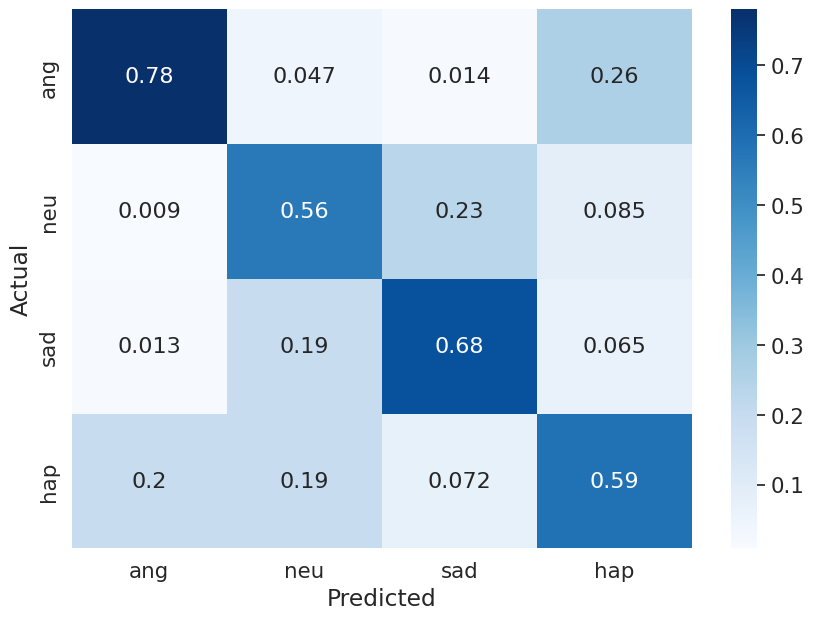

In [23]:
labels = dataset_config.target_labels
a = torch.tensor(
    [[174,  11,   4,  65],
        [  2, 131,  64,  21],
        [  3,  45, 190,  16],
        [ 44,  45,  20, 145]], dtype=torch.float)
# a /= reduce(a, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels )
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

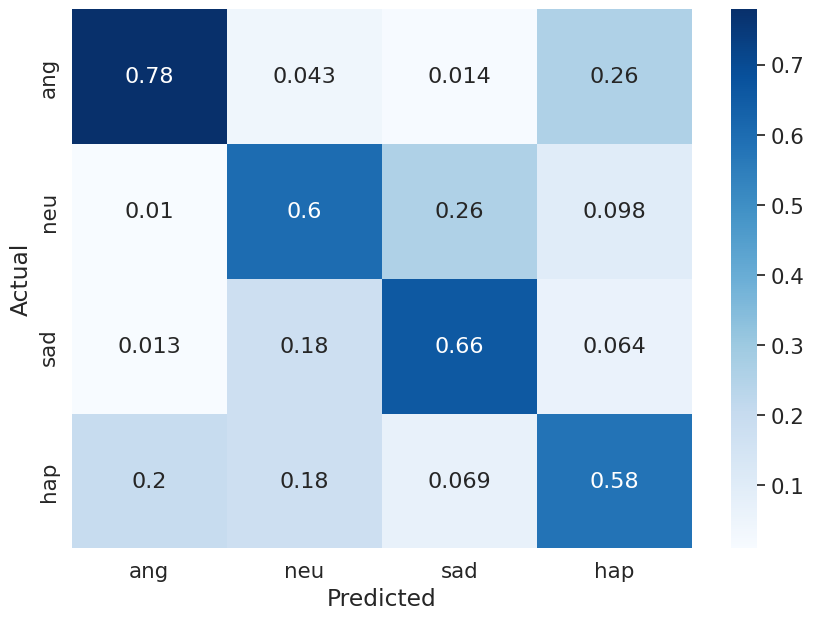

In [24]:
labels = dataset_config.target_labels
a = torch.tensor(
    [[174,  11,   4,  65],
        [  2, 131,  64,  21],
        [  3,  45, 190,  16],
        [ 44,  45,  20, 145]], dtype=torch.float)
a /= reduce(a, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels )
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [25]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df2 = pd.DataFrame(dt)
loss_df2

,loss,perplexity,loss_vq,loss_recon,loss_cls
0,6.039802,84.473381,0.047872,5.818679,1.732513
1,4.823287,116.092453,0.055162,4.683243,0.848832
2,6.549064,130.395859,0.057066,6.371131,1.208674
3,4.994544,120.209732,0.052171,4.806386,1.359874
4,4.399300,96.783211,0.046779,4.158292,1.942298
...,...,...,...,...,...
140915,5.701995,128.827805,0.056067,5.645865,0.000625
140916,4.831396,128.135941,0.052734,4.778663,0.000000
140917,6.677876,108.753860,0.056666,6.621194,0.000158
140918,6.098968,101.641151,0.048938,6.050009,0.000207


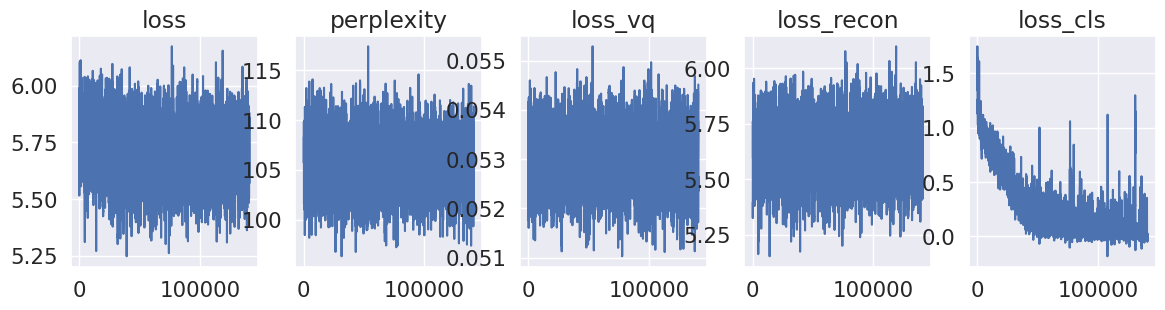

In [26]:
from scipy.signal import savgol_filter

fig, axes = plt.subplots(1, 5, figsize=(14,3))
for i, c in enumerate(loss_df2.columns):
    axes[i].plot(savgol_filter(loss_df2[c], 301, 7))
    axes[i].set_title(c)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

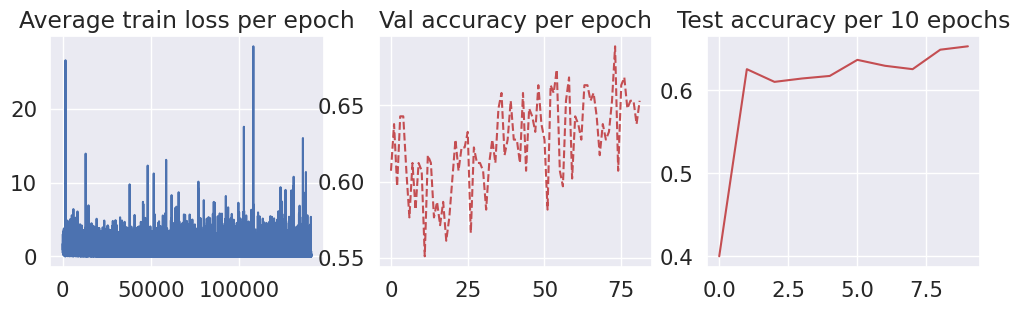

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(loss_df2['loss_cls'].values, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [28]:
train_losses2 = reduce(np.array(loss_df2['loss_cls'].values[:1739*81]), '(n k) -> n', 'mean', n=81)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

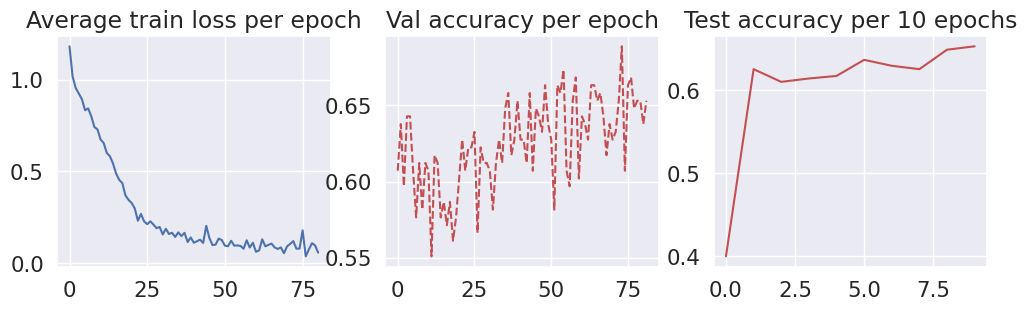

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses2, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

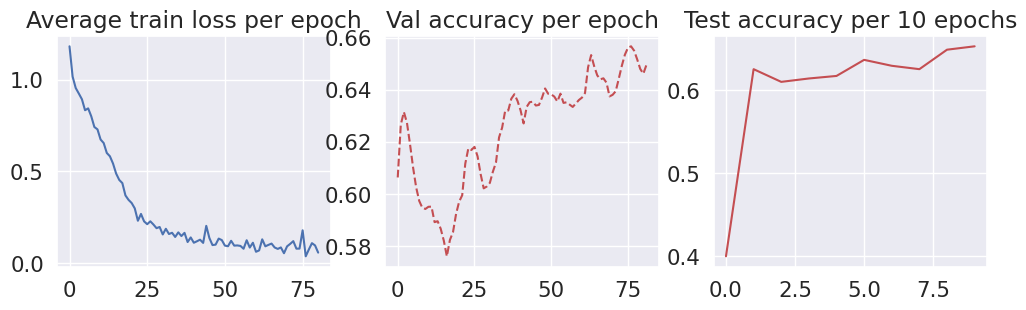

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses2, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 21, 5), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [33]:
trainer.val_accuracy

[0.6071428571428571,
 0.6377551020408163,
 0.5969387755102041,
 0.6428571428571429,
 0.6428571428571429,
 0.6071428571428571,
 0.576530612244898,
 0.6122448979591837,
 0.5816326530612245,
 0.6122448979591837,
 0.6071428571428571,
 0.5510204081632653,
 0.6173469387755102,
 0.6122448979591837,
 0.576530612244898,
 0.5867346938775511,
 0.5714285714285714,
 0.5867346938775511,
 0.5612244897959183,
 0.576530612244898,
 0.6020408163265306,
 0.6275510204081632,
 0.6071428571428571,
 0.6224489795918368,
 0.6224489795918368,
 0.6326530612244898,
 0.5663265306122449,
 0.6224489795918368,
 0.6122448979591837,
 0.6122448979591837,
 0.6071428571428571,
 0.5816326530612245,
 0.6122448979591837,
 0.6275510204081632,
 0.6122448979591837,
 0.6479591836734694,
 0.6581632653061225,
 0.6173469387755102,
 0.6275510204081632,
 0.6530612244897959,
 0.6275510204081632,
 0.6275510204081632,
 0.6122448979591837,
 0.6581632653061225,
 0.6071428571428571,
 0.6479591836734694,
 0.6428571428571429,
 0.6326530612244

In [34]:
trainer.test_accuracy

[0.4,
 0.6255102040816326,
 0.610204081632653,
 0.6142857142857143,
 0.6173469387755102,
 0.636734693877551,
 0.6295918367346939,
 0.6255102040816326,
 0.6489795918367347,
 0.6530612244897959]

In [35]:
loss_df2.to_csv(log_dir+"train_losses.csv")

In [39]:
me = metrics.cpu().compute()
me

{'acc_unweighted': tensor(0.6512),
 'acc_weighted': tensor(0.6512),
 'f1s_unweighted': tensor(0.6512),
 'f1s_weighted': tensor(0.6512),
 'rocauc': tensor(0.8602),
 'uar': tensor(0.6512),
 'wap': tensor(0.6512)}

In [40]:
med = metrics_details.cpu().compute()
med

{'acc_detail': tensor([0.6850, 0.6009, 0.7480, 0.5709]),
 'f1s_detail': tensor([0.6850, 0.6009, 0.7480, 0.5709]),
 'precision_detail': tensor([0.6850, 0.6009, 0.7480, 0.5709]),
 'recall_detail': tensor([0.6850, 0.6009, 0.7480, 0.5709]),
 'rocauc_detail': tensor([0.9091, 0.8572, 0.9020, 0.7728])}

In [41]:
cm = confusion_matrix.cpu().compute()

In [42]:
cm

tensor([[174,  11,   4,  65],
        [  2, 131,  64,  21],
        [  3,  45, 190,  16],
        [ 44,  45,  20, 145]])

In [46]:
train_log = {
    'train_loss': torch.tensor(train_losses2),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med
}
train_log

{'train_loss': tensor([1.1829, 1.0174, 0.9552, 0.9250, 0.8937, 0.8339, 0.8441, 0.8008, 0.7424,
         0.7294, 0.6741, 0.6547, 0.6006, 0.5826, 0.5429, 0.4883, 0.4535, 0.4361,
         0.3688, 0.3445, 0.3274, 0.2980, 0.2306, 0.2678, 0.2271, 0.2118, 0.2275,
         0.2100, 0.1901, 0.1965, 0.1559, 0.1868, 0.1582, 0.1650, 0.1422, 0.1672,
         0.1471, 0.1645, 0.1144, 0.1395, 0.1105, 0.1186, 0.1272, 0.1097, 0.2027,
         0.1364, 0.0978, 0.1001, 0.1332, 0.1250, 0.0947, 0.0916, 0.1211, 0.0948,
         0.0959, 0.0931, 0.0778, 0.1242, 0.0842, 0.1105, 0.0613, 0.0685, 0.1291,
         0.0911, 0.0988, 0.1060, 0.0847, 0.0769, 0.0850, 0.0533, 0.0909, 0.1043,
         0.1193, 0.0782, 0.0786, 0.1784, 0.0365, 0.0736, 0.1083, 0.0958, 0.0566],
        dtype=torch.float64),
 'val_acc': tensor([0.6071, 0.6378, 0.5969, 0.6429, 0.6429, 0.6071, 0.5765, 0.6122, 0.5816,
         0.6122, 0.6071, 0.5510, 0.6173, 0.6122, 0.5765, 0.5867, 0.5714, 0.5867,
         0.5612, 0.5765, 0.6020, 0.6276, 0.6071, 0.62

In [47]:
torch.save(train_log, log_dir+"train_metrics.pt")

In [ ]:
model.encoder.freeze_codebook = False

In [49]:
model.encoder.vq.learnable_codebook = True

In [50]:
model.encoder.vq.embedding.freeze = False

In [51]:
model.encoder.vq.embedding._freeze = False

In [52]:
len(trainer.test_accuracy)

10

In [53]:
len(trainer.val_accuracy)

82

In [54]:
len(trainer.train_losses)

140920

In [55]:
trainer.setup(model, learning_rate)

In [56]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0.1, loss_recon=0.1, loss_cls=1)

trainer.fit(
    n_epoch=10, lr=learning_rate, self_supervised=False, 
    train_task='embedding', test_n_epoch=2)

  4%|███▏                                                                            | 0.40040816326531004/10 [06:09<79:44:46, 29906.17s/it]

Epoch: 1	Loss: 5.027 [perplexity=108.624, loss_vq=0.057, loss_recon=4.970, loss_cls=0.000]	Val_acc: 127/196 (64.80%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=1.step=858.loss=5.027.val_acc=0.648.pt


 12%|██████████                                                                          | 1.2000000000000135/10 [16:23<1:43:10, 703.52s/it]

Correct: 630/980 (0.6429)
Saved new best test model: ../scb14_models/crema_d/model.epoch=1.step=1715.test_acc=0.6429.pt
{'acc_unweighted': tensor(0.6370, device='cuda:0'),
 'acc_weighted': tensor(0.6429, device='cuda:0'),
 'f1s_unweighted': tensor(0.6355, device='cuda:0'),
 'f1s_weighted': tensor(0.6396, device='cuda:0'),
 'rocauc': tensor(0.8635, device='cuda:0'),
 'uar': tensor(0.6370, device='cuda:0'),
 'wap': tensor(0.6461, device='cuda:0')}
{'acc_detail': tensor([0.6850, 0.4771, 0.8110, 0.5748], device='cuda:0'),
 'f1s_detail': tensor([0.7326, 0.5253, 0.7116, 0.5725], device='cuda:0'),
 'precision_detail': tensor([0.7873, 0.5843, 0.6338, 0.5703], device='cuda:0'),
 'recall_detail': tensor([0.6850, 0.4771, 0.8110, 0.5748], device='cuda:0'),
 'rocauc_detail': tensor([0.9184, 0.8436, 0.9013, 0.7906], device='cuda:0')}
tensor([[174,   3,   5,  72],
        [  1, 104,  90,  23],
        [  1,  32, 206,  15],
        [ 45,  39,  24, 146]], device='cuda:0')


 16%|████████████▉                                                                    | 1.6004081632653244/10 [22:42<69:25:08, 29752.50s/it]

Epoch: 2	Loss: 6.257 [perplexity=130.317, loss_vq=0.062, loss_recon=6.194, loss_cls=0.001]	Val_acc: 128/196 (65.31%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=2.step=2573.loss=6.257.val_acc=0.653.pt


 24%|███████████████████▋                                                              | 2.400408163265116/10 [34:40<63:53:34, 30266.70s/it]

Epoch: 3	Loss: 7.444 [perplexity=89.559, loss_vq=0.054, loss_recon=7.389, loss_cls=0.000]	Val_acc: 130/196 (66.33%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=3.step=4288.loss=7.444.val_acc=0.663.pt


 32%|██████████████████████████▉                                                         | 3.1999999999993847/10 [44:57<1:20:47, 712.86s/it]

Correct: 615/980 (0.6276)
{'acc_unweighted': tensor(0.6214, device='cuda:0'),
 'acc_weighted': tensor(0.6276, device='cuda:0'),
 'f1s_unweighted': tensor(0.6177, device='cuda:0'),
 'f1s_weighted': tensor(0.6216, device='cuda:0'),
 'rocauc': tensor(0.8488, device='cuda:0'),
 'uar': tensor(0.6214, device='cuda:0'),
 'wap': tensor(0.6221, device='cuda:0')}
{'acc_detail': tensor([0.7992, 0.4541, 0.7165, 0.5157], device='cuda:0'),
 'f1s_detail': tensor([0.7368, 0.5130, 0.7013, 0.5198], device='cuda:0'),
 'precision_detail': tensor([0.6835, 0.5893, 0.6868, 0.5240], device='cuda:0'),
 'recall_detail': tensor([0.7992, 0.4541, 0.7165, 0.5157], device='cuda:0'),
 'rocauc_detail': tensor([0.9123, 0.8611, 0.8951, 0.7268], device='cuda:0')}
tensor([[203,   3,   4,  44],
        [  5,  99,  62,  52],
        [  6,  43, 182,  23],
        [ 83,  23,  17, 131]], device='cuda:0')


 36%|█████████████████████████████▏                                                   | 3.6004081632644778/10 [51:19<53:11:15, 29919.92s/it]

Epoch: 4	Loss: 3.660 [perplexity=97.723, loss_vq=0.047, loss_recon=3.613, loss_cls=0.000]	Val_acc: 129/196 (65.82%)



 44%|███████████████████████████████████▏                                            | 4.400408163264488/10 [1:03:18<46:41:19, 30016.36s/it]

Epoch: 5	Loss: 5.215 [perplexity=124.681, loss_vq=0.063, loss_recon=5.150, loss_cls=0.014]	Val_acc: 132/196 (67.35%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=5.step=7718.loss=5.215.val_acc=0.673.pt


 52%|████████████████████████████████████████████▏                                        | 5.199999999999626/10 [1:13:41<56:25, 705.39s/it]

Correct: 624/980 (0.6367)
{'acc_unweighted': tensor(0.6325, device='cuda:0'),
 'acc_weighted': tensor(0.6367, device='cuda:0'),
 'f1s_unweighted': tensor(0.6304, device='cuda:0'),
 'f1s_weighted': tensor(0.6340, device='cuda:0'),
 'rocauc': tensor(0.8635, device='cuda:0'),
 'uar': tensor(0.6325, device='cuda:0'),
 'wap': tensor(0.6398, device='cuda:0')}
{'acc_detail': tensor([0.6772, 0.5183, 0.8071, 0.5276], device='cuda:0'),
 'f1s_detail': tensor([0.7257, 0.5330, 0.7081, 0.5549], device='cuda:0'),
 'precision_detail': tensor([0.7818, 0.5485, 0.6308, 0.5852], device='cuda:0'),
 'recall_detail': tensor([0.6772, 0.5183, 0.8071, 0.5276], device='cuda:0'),
 'rocauc_detail': tensor([0.9155, 0.8430, 0.9052, 0.7901], device='cuda:0')}
tensor([[172,   8,   7,  67],
        [  1, 113,  88,  16],
        [  1,  36, 205,  12],
        [ 46,  49,  25, 134]], device='cuda:0')


 56%|████████████████████████████████████████████▊                                   | 5.600408163265155/10 [1:20:06<36:54:56, 30206.47s/it]

Epoch: 6	Loss: 4.395 [perplexity=143.222, loss_vq=0.057, loss_recon=4.338, loss_cls=0.000]	Val_acc: 127/196 (64.80%)



 64%|████████████████████████████████████████████████████▍                             | 6.4004081632656/10 [1:32:15<30:50:47, 30850.10s/it]

Epoch: 7	Loss: 3.836 [perplexity=111.958, loss_vq=0.054, loss_recon=3.781, loss_cls=0.000]	Val_acc: 120/196 (61.22%)



 72%|█████████████████████████████████████████████████████████████▏                       | 7.200000000000738/10 [1:42:45<33:45, 723.24s/it]

Correct: 599/980 (0.6112)
{'acc_unweighted': tensor(0.6092, device='cuda:0'),
 'acc_weighted': tensor(0.6112, device='cuda:0'),
 'f1s_unweighted': tensor(0.6074, device='cuda:0'),
 'f1s_weighted': tensor(0.6102, device='cuda:0'),
 'rocauc': tensor(0.8417, device='cuda:0'),
 'uar': tensor(0.6092, device='cuda:0'),
 'wap': tensor(0.6244, device='cuda:0')}
{'acc_detail': tensor([0.8110, 0.5550, 0.5433, 0.5276], device='cuda:0'),
 'f1s_detail': tensor([0.7357, 0.5307, 0.6419, 0.5214], device='cuda:0'),
 'precision_detail': tensor([0.6732, 0.5084, 0.7841, 0.5154], device='cuda:0'),
 'recall_detail': tensor([0.8110, 0.5550, 0.5433, 0.5276], device='cuda:0'),
 'rocauc_detail': tensor([0.9062, 0.8489, 0.8951, 0.7165], device='cuda:0')}
tensor([[206,   4,   2,  42],
        [  9, 121,  27,  61],
        [  7,  86, 138,  23],
        [ 84,  27,   9, 134]], device='cuda:0')


 76%|████████████████████████████████████████████████████████████▊                   | 7.600408163266267/10 [1:49:07<20:16:28, 30417.18s/it]

Epoch: 8	Loss: 6.140 [perplexity=94.350, loss_vq=0.057, loss_recon=6.083, loss_cls=0.001]	Val_acc: 129/196 (65.82%)



 84%|████████████████████████████████████████████████████████████████████             | 8.40040816326584/10 [2:01:05<13:38:57, 30718.59s/it]

Epoch: 9	Loss: 5.750 [perplexity=102.335, loss_vq=0.058, loss_recon=5.692, loss_cls=0.002]	Val_acc: 127/196 (64.80%)



 92%|██████████████████████████████████████████████████████████████████████████████▏      | 9.199999999999239/10 [2:11:28<09:36, 720.72s/it]

Correct: 614/980 (0.6265)
{'acc_unweighted': tensor(0.6272, device='cuda:0'),
 'acc_weighted': tensor(0.6265, device='cuda:0'),
 'f1s_unweighted': tensor(0.6273, device='cuda:0'),
 'f1s_weighted': tensor(0.6289, device='cuda:0'),
 'rocauc': tensor(0.8512, device='cuda:0'),
 'uar': tensor(0.6272, device='cuda:0'),
 'wap': tensor(0.6441, device='cuda:0')}
{'acc_detail': tensor([0.7402, 0.6468, 0.5669, 0.5551], device='cuda:0'),
 'f1s_detail': tensor([0.7231, 0.5839, 0.6621, 0.5402], device='cuda:0'),
 'precision_detail': tensor([0.7068, 0.5321, 0.7956, 0.5261], device='cuda:0'),
 'recall_detail': tensor([0.7402, 0.6468, 0.5669, 0.5551], device='cuda:0'),
 'rocauc_detail': tensor([0.9024, 0.8615, 0.8895, 0.7514], device='cuda:0')}
tensor([[188,   5,   1,  60],
        [  2, 141,  27,  48],
        [  6,  85, 144,  19],
        [ 70,  34,   9, 141]], device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 9.600408163263896/10 [2:17:51<3:29:51, 31511.32s/it]

Epoch: 10	Loss: 5.851 [perplexity=106.053, loss_vq=0.054, loss_recon=5.798, loss_cls=0.002]	Val_acc: 125/196 (63.78%)



100%|████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999997943/10 [2:23:30<00:00, 861.02s/it]


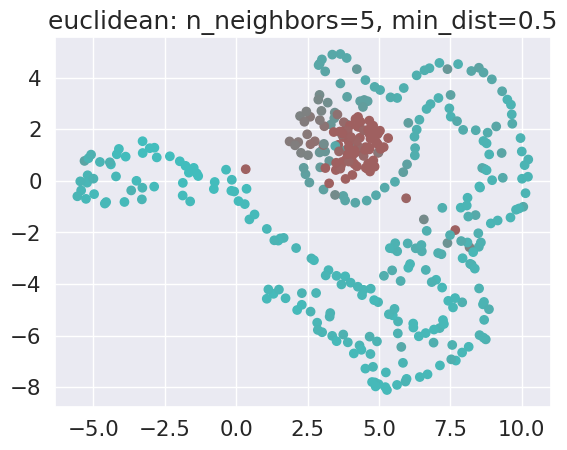

In [57]:
emb = model.embedding_filters.data.cpu()
emb_color, zcs = get_embedding_color_v2(emb)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(emb, colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

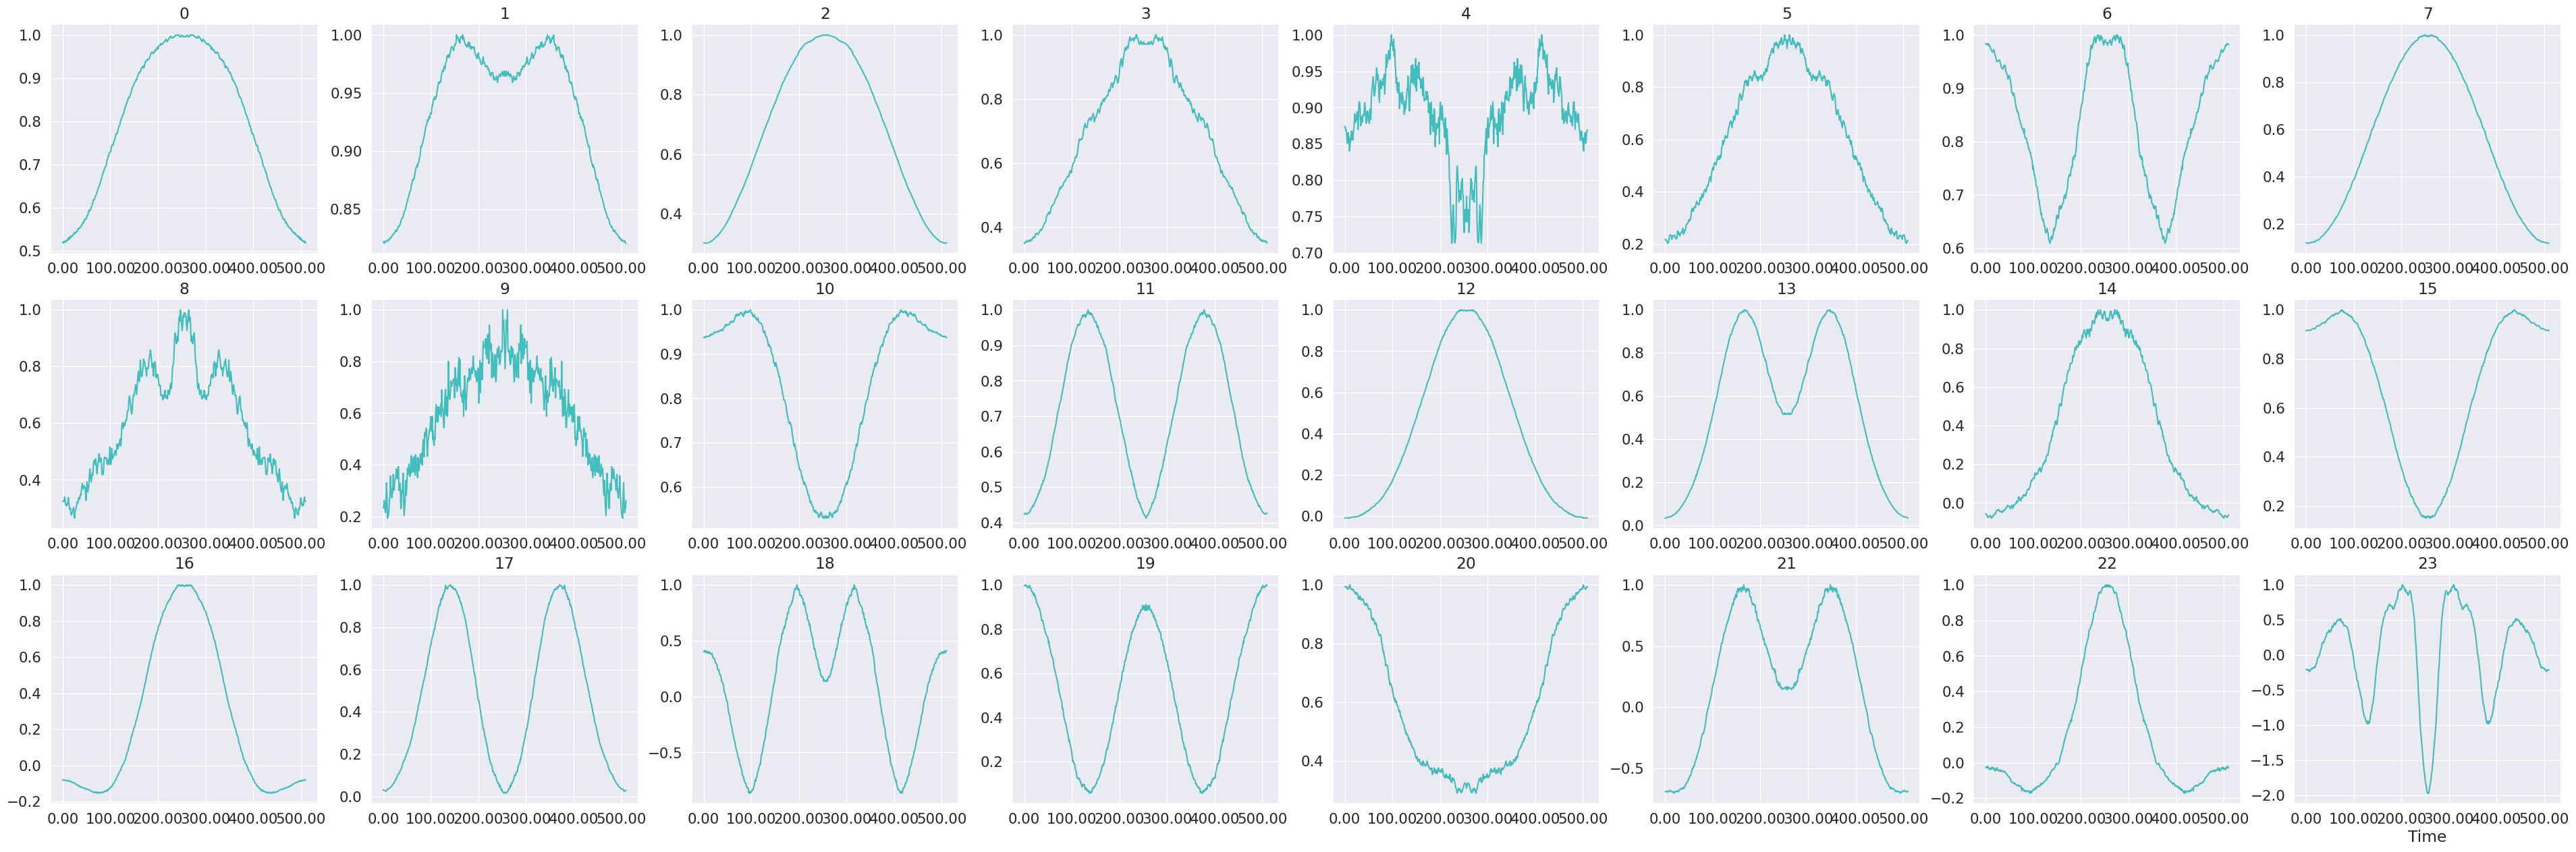

In [58]:
selected_emb_topk = torch.topk(zcs, 24)
selected_idx = selected_emb_topk.indices[-24:]
visualize_speech_codebook(
    emb[selected_idx].numpy(), 
    n=24, colors=emb_color[selected_idx], 
    feature_mel=False, waveplot_librosa=False)

In [59]:
trainer.load_best_model(val_model=True)

Loaded: ../scb14_models/crema_d/model.epoch=5.step=7718.loss=5.215.val_acc=0.673.pt


In [60]:
metrics2, metrics_details2, confusion_matrix2 = trainer.test_step()

Correct: 631/980 (0.6439)
Saved new best test model: ../scb14_models/crema_d/model.epoch=10.step=17150.test_acc=0.6439.pt


In [61]:
pprint(metrics2.compute())
pprint(metrics_details2.compute())
pprint(confusion_matrix2.compute())

{'acc_unweighted': tensor(0.6440, device='cuda:0'),
 'acc_weighted': tensor(0.6439, device='cuda:0'),
 'f1s_unweighted': tensor(0.6446, device='cuda:0'),
 'f1s_weighted': tensor(0.6463, device='cuda:0'),
 'rocauc': tensor(0.8565, device='cuda:0'),
 'uar': tensor(0.6440, device='cuda:0'),
 'wap': tensor(0.6545, device='cuda:0')}
{'acc_detail': tensor([0.7402, 0.6468, 0.6063, 0.5827], device='cuda:0'),
 'f1s_detail': tensor([0.7475, 0.5975, 0.6696, 0.5638], device='cuda:0'),
 'precision_detail': tensor([0.7550, 0.5551, 0.7476, 0.5461], device='cuda:0'),
 'recall_detail': tensor([0.7402, 0.6468, 0.6063, 0.5827], device='cuda:0'),
 'rocauc_detail': tensor([0.9146, 0.8613, 0.8888, 0.7611], device='cuda:0')}
tensor([[188,   3,   4,  59],
        [  2, 141,  34,  41],
        [  2,  75, 154,  23],
        [ 57,  35,  14, 148]], device='cuda:0')


In [62]:
model.encoder.freeze_codebook = False

In [63]:
model.freeze_codebook = False

In [64]:
model.encoder.load_codebook(codebook_pretrained_path, freeze=False)

In [65]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0.1, loss_recon=0.1, loss_cls=1)

trainer.fit(
    n_epoch=10, lr=learning_rate, self_supervised=False, 
    train_task='embedding', test_n_epoch=2, loss_ratio=loss_ratio)

  4%|███▏                                                                            | 0.40040816326531004/10 [07:32<85:27:52, 32050.63s/it]

Epoch: 11	Loss: 0.767 [perplexity=110.191, loss_vq=0.064, loss_recon=7.599, loss_cls=0.000]	Val_acc: 119/196 (60.71%)



 12%|██████████                                                                          | 1.2000000000000135/10 [19:32<1:52:39, 768.12s/it]

Correct: 588/980 (0.6000)
{'acc_unweighted': tensor(0.5940, device='cuda:0'),
 'acc_weighted': tensor(0.6000, device='cuda:0'),
 'f1s_unweighted': tensor(0.5955, device='cuda:0'),
 'f1s_weighted': tensor(0.5992, device='cuda:0'),
 'rocauc': tensor(0.8610, device='cuda:0'),
 'uar': tensor(0.5940, device='cuda:0'),
 'wap': tensor(0.6191, device='cuda:0')}
{'acc_detail': tensor([0.5591, 0.4312, 0.7362, 0.6496], device='cuda:0'),
 'f1s_detail': tensor([0.6440, 0.4947, 0.6913, 0.5518], device='cuda:0'),
 'precision_detail': tensor([0.7594, 0.5802, 0.6516, 0.4797], device='cuda:0'),
 'recall_detail': tensor([0.5591, 0.4312, 0.7362, 0.6496], device='cuda:0'),
 'rocauc_detail': tensor([0.9110, 0.8533, 0.8946, 0.7851], device='cuda:0')}
tensor([[142,   3,   3, 106],
        [  2,  94,  70,  52],
        [  4,  42, 187,  21],
        [ 39,  23,  27, 165]], device='cuda:0')


 16%|████████████▉                                                                    | 1.6004081632653244/10 [27:10<75:55:52, 32543.55s/it]

Epoch: 12	Loss: 1.004 [perplexity=61.850, loss_vq=0.060, loss_recon=4.524, loss_cls=0.546]	Val_acc: 116/196 (59.18%)



 24%|███████████████████▋                                                              | 2.400408163265116/10 [41:36<67:43:23, 32081.12s/it]

Epoch: 13	Loss: 0.534 [perplexity=113.782, loss_vq=0.078, loss_recon=5.208, loss_cls=0.005]	Val_acc: 132/196 (67.35%)



 32%|██████████████████████████▉                                                         | 3.1999999999993847/10 [53:33<1:26:55, 766.97s/it]

Correct: 527/980 (0.5378)
{'acc_unweighted': tensor(0.5291, device='cuda:0'),
 'acc_weighted': tensor(0.5378, device='cuda:0'),
 'f1s_unweighted': tensor(0.5129, device='cuda:0'),
 'f1s_weighted': tensor(0.5170, device='cuda:0'),
 'rocauc': tensor(0.8480, device='cuda:0'),
 'uar': tensor(0.5291, device='cuda:0'),
 'wap': tensor(0.6151, device='cuda:0')}
{'acc_detail': tensor([0.3031, 0.2936, 0.7717, 0.7480], device='cuda:0'),
 'f1s_detail': tensor([0.4413, 0.4025, 0.6735, 0.5345], device='cuda:0'),
 'precision_detail': tensor([0.8105, 0.6400, 0.5976, 0.4158], device='cuda:0'),
 'recall_detail': tensor([0.3031, 0.2936, 0.7717, 0.7480], device='cuda:0'),
 'rocauc_detail': tensor([0.8973, 0.8419, 0.8902, 0.7627], device='cuda:0')}
tensor([[ 77,   2,   5, 170],
        [  1,  64,  95,  58],
        [  1,  18, 196,  39],
        [ 16,  16,  32, 190]], device='cuda:0')


 36%|████████████████████████████▍                                                  | 3.6004081632644778/10 [1:01:26<57:06:25, 32124.77s/it]

Epoch: 14	Loss: 0.677 [perplexity=85.532, loss_vq=0.080, loss_recon=6.680, loss_cls=0.001]	Val_acc: 107/196 (54.59%)



 44%|███████████████████████████████████▏                                            | 4.400408163264488/10 [1:16:18<50:10:38, 32259.17s/it]

Epoch: 15	Loss: 0.801 [perplexity=99.372, loss_vq=0.097, loss_recon=5.865, loss_cls=0.205]	Val_acc: 123/196 (62.76%)



 52%|███████████████████████████████████████████▏                                       | 5.199999999999626/10 [1:28:34<1:01:51, 773.18s/it]

Correct: 585/980 (0.5969)
{'acc_unweighted': tensor(0.5977, device='cuda:0'),
 'acc_weighted': tensor(0.5969, device='cuda:0'),
 'f1s_unweighted': tensor(0.5965, device='cuda:0'),
 'f1s_weighted': tensor(0.5981, device='cuda:0'),
 'rocauc': tensor(0.8466, device='cuda:0'),
 'uar': tensor(0.5977, device='cuda:0'),
 'wap': tensor(0.6250, device='cuda:0')}
{'acc_detail': tensor([0.7598, 0.6193, 0.4882, 0.5236], device='cuda:0'),
 'f1s_detail': tensor([0.7201, 0.5521, 0.6108, 0.5028], device='cuda:0'),
 'precision_detail': tensor([0.6844, 0.4982, 0.8158, 0.4836], device='cuda:0'),
 'recall_detail': tensor([0.7598, 0.6193, 0.4882, 0.5236], device='cuda:0'),
 'rocauc_detail': tensor([0.9099, 0.8356, 0.8840, 0.7571], device='cuda:0')}
tensor([[193,   8,   0,  53],
        [  2, 135,  20,  61],
        [  6,  96, 124,  28],
        [ 81,  32,   8, 133]], device='cuda:0')


 56%|████████████████████████████████████████████▊                                   | 5.600408163265155/10 [1:36:26<39:15:03, 32117.46s/it]

Epoch: 16	Loss: 0.551 [perplexity=98.227, loss_vq=0.106, loss_recon=5.211, loss_cls=0.019]	Val_acc: 133/196 (67.86%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=16.step=26583.loss=0.551.val_acc=0.679.pt


 64%|████████████████████████████████████████████████████▍                             | 6.4004081632656/10 [1:51:25<32:30:04, 32504.94s/it]

Epoch: 17	Loss: 0.722 [perplexity=122.450, loss_vq=0.126, loss_recon=7.095, loss_cls=0.000]	Val_acc: 129/196 (65.82%)



 72%|█████████████████████████████████████████████████████████████▏                       | 7.200000000000738/10 [2:03:40<36:22, 779.37s/it]

Correct: 610/980 (0.6224)
{'acc_unweighted': tensor(0.6223, device='cuda:0'),
 'acc_weighted': tensor(0.6224, device='cuda:0'),
 'f1s_unweighted': tensor(0.6239, device='cuda:0'),
 'f1s_weighted': tensor(0.6257, device='cuda:0'),
 'rocauc': tensor(0.8616, device='cuda:0'),
 'uar': tensor(0.6223, device='cuda:0'),
 'wap': tensor(0.6411, device='cuda:0')}
{'acc_detail': tensor([0.5669, 0.6193, 0.6693, 0.6339], device='cuda:0'),
 'f1s_detail': tensor([0.6560, 0.5745, 0.6827, 0.5823], device='cuda:0'),
 'precision_detail': tensor([0.7784, 0.5357, 0.6967, 0.5385], device='cuda:0'),
 'recall_detail': tensor([0.5669, 0.6193, 0.6693, 0.6339], device='cuda:0'),
 'rocauc_detail': tensor([0.9015, 0.8525, 0.8989, 0.7935], device='cuda:0')}
tensor([[144,  11,   2,  97],
        [  2, 135,  55,  26],
        [  2,  67, 170,  15],
        [ 37,  39,  17, 161]], device='cuda:0')


 76%|████████████████████████████████████████████████████████████▊                   | 7.600408163266267/10 [2:11:33<21:40:45, 32524.48s/it]

Epoch: 18	Loss: 0.517 [perplexity=117.908, loss_vq=0.140, loss_recon=3.790, loss_cls=0.124]	Val_acc: 129/196 (65.82%)



 84%|████████████████████████████████████████████████████████████████████             | 8.40040816326584/10 [2:26:34<14:39:49, 33001.64s/it]

Epoch: 19	Loss: 1.903 [perplexity=73.736, loss_vq=0.146, loss_recon=6.415, loss_cls=1.247]	Val_acc: 132/196 (67.35%)



 92%|██████████████████████████████████████████████████████████████████████████████▏      | 9.199999999999239/10 [2:38:58<10:37, 796.75s/it]

Correct: 583/980 (0.5949)
{'acc_unweighted': tensor(0.5854, device='cuda:0'),
 'acc_weighted': tensor(0.5949, device='cuda:0'),
 'f1s_unweighted': tensor(0.5817, device='cuda:0'),
 'f1s_weighted': tensor(0.5880, device='cuda:0'),
 'rocauc': tensor(0.8428, device='cuda:0'),
 'uar': tensor(0.5854, device='cuda:0'),
 'wap': tensor(0.6012, device='cuda:0')}
{'acc_detail': tensor([0.7677, 0.3257, 0.6496, 0.5984], device='cuda:0'),
 'f1s_detail': tensor([0.7182, 0.4104, 0.6776, 0.5205], device='cuda:0'),
 'precision_detail': tensor([0.6747, 0.5547, 0.7082, 0.4606], device='cuda:0'),
 'recall_detail': tensor([0.7677, 0.3257, 0.6496, 0.5984], device='cuda:0'),
 'rocauc_detail': tensor([0.8999, 0.8451, 0.8923, 0.7341], device='cuda:0')}
tensor([[195,   2,   3,  54],
        [ 14,  71,  49,  84],
        [  7,  42, 165,  40],
        [ 73,  13,  16, 152]], device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 9.600408163263896/10 [2:46:55<3:38:56, 32875.04s/it]

Epoch: 20	Loss: 0.906 [perplexity=56.277, loss_vq=0.162, loss_recon=7.386, loss_cls=0.151]	Val_acc: 138/196 (70.41%)

Saved new best val model: ../scb14_models/crema_d/model.epoch=20.step=33443.loss=0.906.val_acc=0.704.pt


100%|███████████████████████████████████████████████████████████████████████████████████▉| 9.999999999997943/10 [2:54:01<00:00, 1044.13s/it]


In [68]:
trainer.load_best_model(val_model=True)

Loaded: ../scb14_models/crema_d/model.epoch=20.step=33443.loss=0.906.val_acc=0.704.pt


In [69]:
metrics3, metrics_details3, confusion_matrix3 = trainer.test_step()

Correct: 623/980 (0.6357)


In [70]:
pprint(metrics3.compute())
pprint(metrics_details3.compute())
pprint(confusion_matrix3.compute())

{'acc_unweighted': tensor(0.6319, device='cuda:0'),
 'acc_weighted': tensor(0.6357, device='cuda:0'),
 'f1s_unweighted': tensor(0.6290, device='cuda:0'),
 'f1s_weighted': tensor(0.6315, device='cuda:0'),
 'rocauc': tensor(0.8567, device='cuda:0'),
 'uar': tensor(0.6319, device='cuda:0'),
 'wap': tensor(0.6306, device='cuda:0')}
{'acc_detail': tensor([0.7598, 0.5275, 0.7323, 0.5079], device='cuda:0'),
 'f1s_detail': tensor([0.7215, 0.5596, 0.7006, 0.5342], device='cuda:0'),
 'precision_detail': tensor([0.6868, 0.5959, 0.6715, 0.5633], device='cuda:0'),
 'recall_detail': tensor([0.7598, 0.5275, 0.7323, 0.5079], device='cuda:0'),
 'rocauc_detail': tensor([0.9028, 0.8518, 0.8902, 0.7820], device='cuda:0')}
tensor([[193,   6,   4,  51],
        [ 12, 115,  60,  31],
        [  8,  42, 186,  18],
        [ 68,  30,  27, 129]], device='cuda:0')


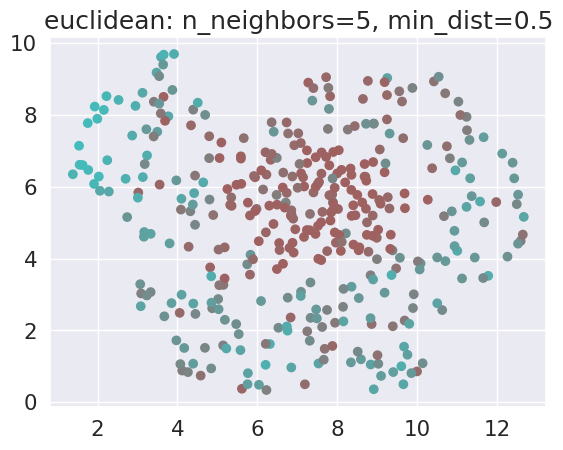

In [71]:
emb2 = model.embedding_filters.data.cpu()
emb_color2, zcs2 = get_embedding_color_v2(emb2)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(emb2, colors=emb_color2, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

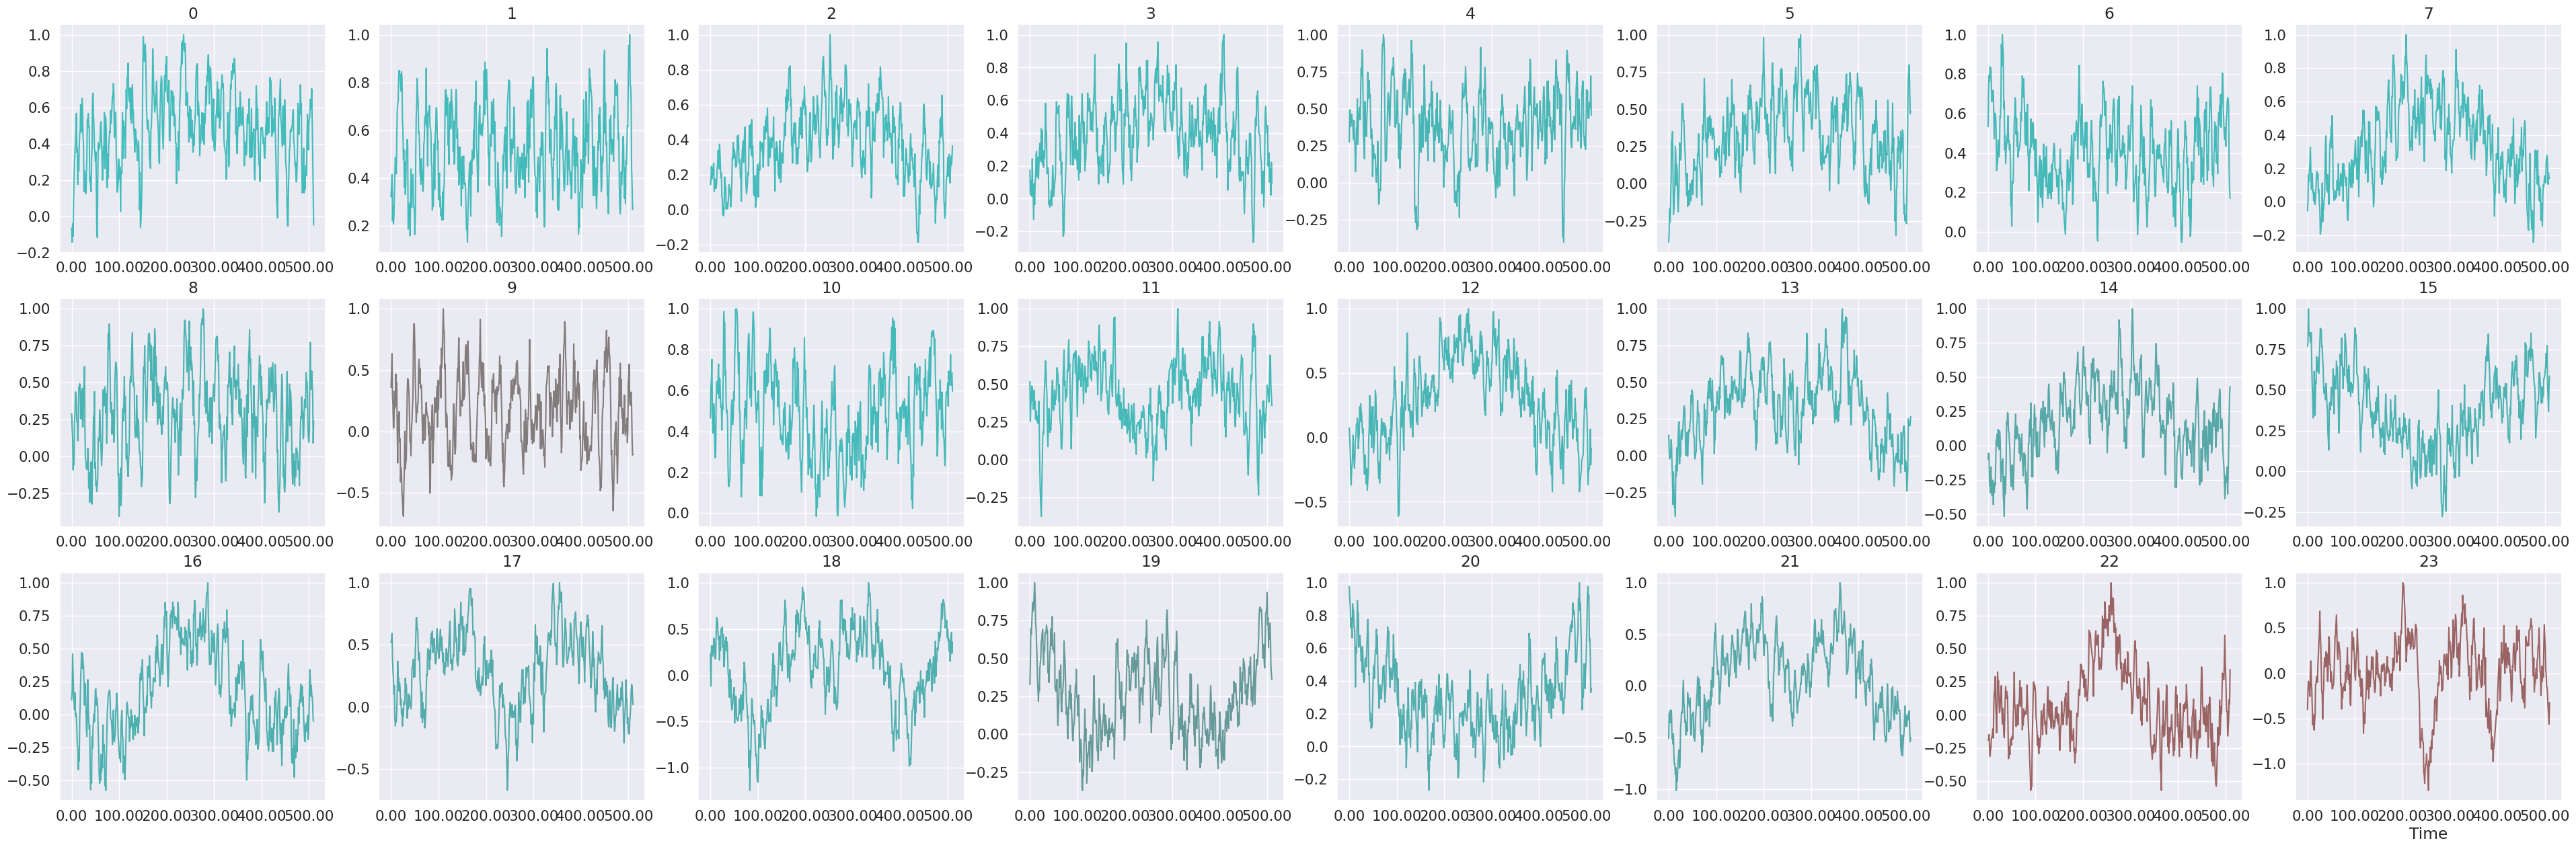

In [72]:
visualize_speech_codebook(
    emb2[selected_idx].numpy(), 
    n=24, colors=emb_color2[selected_idx], 
    feature_mel=False, waveplot_librosa=False)